Projet OC n°5 : Segmenter des clients d'un site e-commerce
==========================================================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import time

from scipy import stats
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap, TSNE, LocallyLinearEmbedding

I. Choix des méthodes de segmentation des donnéess 
*************************************************

In [2]:
data = pd.read_csv('../Data/cleaned_data.csv')

    A.Normalisation des données

In [3]:
# Niveau de signification (alpha)
alpha = 0.05

# Liste pour stocker les résultats
tests = []

# Variables quantitatives à tester
var_quant = ['Review', 'Monetary', 'Frequency', 'Recency']

for column in var_quant:
    # Récupérer les valeurs de la variable
    values = data[column].dropna()

    # Effectuer les tests de normalité pour chaque variable
    shapiro_test = stats.shapiro(values)
    ks_test = stats.kstest(values, 'norm', N=len(values))
    ad_test = stats.anderson(values, dist='norm')
    dagostino_test = stats.normaltest(values)

    # Ajouter les résultats à la liste pour chaque test et variable
    tests.append({
        'Variable': column,
        'Shapiro-Wilk': shapiro_test[1] > alpha,
        'Kolmogorov-Smirnov': ks_test.pvalue > alpha,
        'Anderson-Darling': any(ad_test.statistic < crit_val for crit_val in ad_test.critical_values),
        'D\'Agostino-Pearson': dagostino_test.pvalue > alpha,
    })

# Création d'un DataFrame avec les résultats
test_results = pd.DataFrame(tests)

test_results

C:\Users\laure\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Variable  Shapiro-Wilk  Kolmogorov-Smirnov  Anderson-Darling  \
0     Review         False               False             False   
1   Monetary         False               False             False   
2  Frequency         False               False             False   
3    Recency         False               False             False   

   D'Agostino-Pearson  
0               False  
1               False  
2               False  
3               False

Les résultats des tests de normalité indiquent qu'aucune variables ne suit une distribution normale. Je vais donc normaliser ces caractéristiques.

       1. Comparaison des méthodes de normalisation

In [4]:
# Colonnes quantitatives à normaliser
var_quant = ['Review', 'Monetary', 'Frequency', 'Recency']

# Cloner le DataFrame pour créer des copies
data_min_max = data.copy()
data_standard = data.copy()
data_robust = data.copy()

# Appliquer différentes méthodes de normalisation uniquement sur les colonnes spécifiées
scaler_min_max = MinMaxScaler()
data_min_max[var_quant] = scaler_min_max.fit_transform(data_min_max[var_quant])

scaler_standard = StandardScaler()
data_standard[var_quant] = scaler_standard.fit_transform(data_standard[var_quant])

scaler_robust = RobustScaler()
data_robust[var_quant] = scaler_robust.fit_transform(data_robust[var_quant])

# Initialisation d'un DataFrame vide pour stocker les résultats
results_data = pd.DataFrame(columns=["Normalisation", "Silhouette Score", "Davies-Bouldin Index", "Temps de Calcul"])

# Appliquer l'algorithme de clustering à chaque version normalisée des données
for name, dataset in tqdm(zip(["Min-Max", "Standard", "Robust"], [data_min_max, data_standard, data_robust]), total=3, desc="Traitement"):
    start_time = time.time()  # Commencer à mesurer le temps
    
    # Utiliser KMeans comme exemple d'algorithme de clustering
    kmeans = KMeans(n_clusters=3) 
    labels = kmeans.fit_predict(dataset[var_quant])  # Utiliser seulement les colonnes normalisées pour le clustering
    
    # Évaluer la performance de chaque méthode de normalisation
    silhouette_avg = silhouette_score(dataset[var_quant], labels)
    davies_bouldin = davies_bouldin_score(dataset[var_quant], labels)
    
    end_time = time.time()  # Fin de la mesure du temps
    temps_calcul = end_time - start_time  # Calculer le temps passé
    
    # Ajouter les résultats dans le DataFrame en utilisant pd.concat
    result = pd.DataFrame({
        "Normalisation": [name],
        "Silhouette Score": [silhouette_avg],
        "Davies-Bouldin Index": [davies_bouldin],
        "Temps de Calcul": [temps_calcul]
    })
    result = result.dropna(how='all', axis=1)
    results_data = pd.concat([results_data, result], ignore_index=True)

# Afficher les résultats
results_data

Traitement:   0%|                                                              | 0/3 [00:00<?, ?it/s]C:\Users\laure\AppData\Local\Temp\ipykernel_12432\2016843359.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_data = pd.concat([results_data, result], ignore_index=True)
Traitement: 100%|█████████████████████████████████████████████████████| 3/3 [07:19<00:00, 146.54s/it]


Normalisation  Silhouette Score  Davies-Bouldin Index  Temps de Calcul
0       Min-Max          0.441741              0.860888       141.141419
1      Standard          0.326620              1.188084       147.521244
2        Robust          0.502436              0.779289       150.945616

Notre étude des méthodes de normalisation a révélé des informations importantes sur leur influence sur la performance des modèles de clustering appliqués à la segmentation client RFM. En utilisant les scores de silhouette et le Davies-Bouldin Index pour évaluer les résultats, ainsi que l'analyse du temps de calcul de chaque méthode, nous avons comparé empiriquement l'efficacité des différentes normalisations sur le clustering.

Robust Scaling s'est avéré être la méthode la plus efficace avec un score de silhouettle plus elevé63, indiquant une meilleure cohérence interne des clusters et une adéquation significative des clients à leurs segments respectifs. Cela montre que le Robust Scaling est particulièrement adapté pour traiter les données RFM qui peuvent contenir des valeurs aberrantes ou avoir une distribution asymétrique, en minimisant leur impact sur la segmentation.

Min-Max Scaling, bien que légèrement inférieur en termes de séparation des clusters avec un Davies-Bouldin Inle plus haut0944, a tout de même produit des clusters bien définis. Cette méthode est donc utile dans des scénarios nécessitant une distinction claire entre les segments.

Standard Scaling, malgré un score de silhouette plus 12249) et un Davies-Bouldin Index plus64262), demeure une option valable lorsque les données suivent une distribution normale. Cependant, pour notre cas spécifique de segmentation client RFM, cette méthode semble moins appropriée, probablement en raison de sa sensibilité aux valeurs aberrantes.

En termes de temps de calcul, les différences entre les méthodes sont marginales, ce qui signifie que le choix de la méthode de normalisation peut principalement se baser sur la qualité du clustering sans compromettre significativement la performance computationnelle.

En résumé, Robust Scaling apparaît comme la méthode de normalisation la plus prometteuse pour notre tâche de segmentation client RFM. Elle offre un équilibre optimal entre cohérence interne des clusters et gestion efficace des valeurs aberrantes, ce qui est crucial pour l'analyse comportementale des clients.

        2. Application de la normalisation

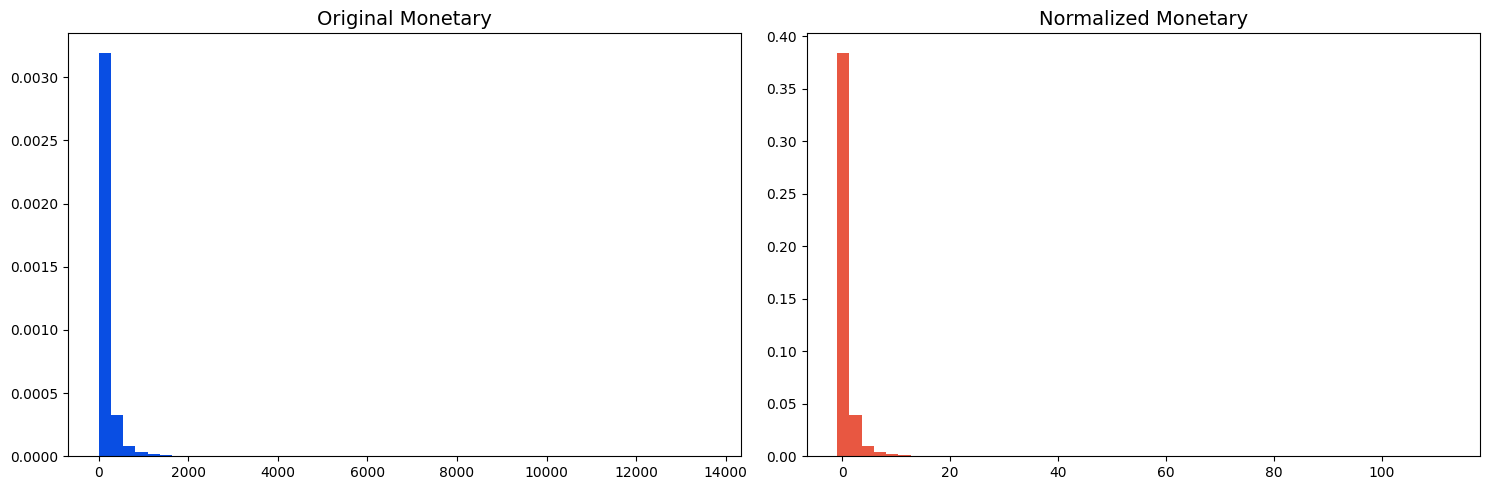

In [5]:
# Colonnes à normaliser avec Robust Scaling
columns_to_scale = ['Review', 'Monetary', 'Frequency', 'Recency']

# Création d'une copie des données originales pour la visualisation
data_original = data.copy()

# Initialisation du RobustScaler
scaler = RobustScaler()

# Application du Robust Scaling sur les colonnes spécifiées de 'data'
data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

# Configuration de la visualisation
fig, axes = plt.subplots(ncols=2, figsize=(15,5))

# Affichage des données originales
axes[0].hist(data_original['Monetary'].dropna(), bins=50, color='#094ee3', density=True, edgecolor='none')
axes[0].set_title('Original Monetary', fontsize=14)

# Affichage des données normalisées
axes[1].hist(data['Monetary'], bins=50, color='#e85741', density=True, edgecolor='none')
axes[1].set_title('Normalized Monetary', fontsize=14)

plt.tight_layout()
plt.show()

    B. Échantillonnage des données

In [6]:
# Échantillonnage aléatoire sans stratification qui contient 20% des données
sample, _ = train_test_split(data, test_size=0.8, random_state=42)

In [7]:
sample.head()

CustomerId  Importance   Recency  Frequency  \
74397  c60c5563690f2a27a76f4d8ba53c2a85       False -0.222222        0.0   
45823  79d64050de51f4f2c5280e88ba96c864       False  0.854701        0.0   
44830  77426f7a06e493a618f5eec875ee7450       False  0.324786        0.0   
19856  34b02e69444e6e159c83d7d6936fb216       False  0.128205        0.0   
42974  72257c3a06b3f5851d40c70240f4e322       False  0.799145        0.0   

       Monetary  Review  
74397 -0.544971     0.0  
45823  0.492401    -2.0  
44830  0.006395     0.0  
19856 -0.216012    -1.0  
42974 -0.212607     0.0

    C. Encoding des variables catégorielles

J'ai opté pour l'encodage One-Hot pour notre variable booléenne Importance. En effet, l'encodage One-Hot est recommandé pour les variables catégorielles nominales sans ordre inhérent, telles que True ou False dans notre cas. Cette méthode permet de traiter chaque catégorie équitablement, sans présumer d'un ordre entre elles. À l'inverse, le Label Encoding est mieux adapté aux variables catégorielles ordinales où l'ordre des catégories est significatif.

In [8]:
# Convertir la colonne 'Importance' en type de données catégorielles
sample['Importance'] = sample['Importance'].astype('category')

# Initialisation de OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Reshape nécessaire car fit_transform attend un 2D array
importance_encoded = encoder.fit_transform(sample[['Importance']])

# Obtenir les noms des colonnes
columns_names = encoder.get_feature_names_out(['Importance'])  # Changer get_feature_names par get_feature_names_out

# Remplacer la colonne 'Importance' dans le dataframe 'sample' par les colonnes encodées
sample = pd.concat([sample.drop(columns=['Importance']), pd.DataFrame(importance_encoded, index=sample.index, columns=columns_names)], axis=1)

# Afficher le résultat
sample

CustomerId   Recency  Frequency  Monetary  \
74397  c60c5563690f2a27a76f4d8ba53c2a85 -0.222222        0.0 -0.544971   
45823  79d64050de51f4f2c5280e88ba96c864  0.854701        0.0  0.492401   
44830  77426f7a06e493a618f5eec875ee7450  0.324786        0.0  0.006395   
19856  34b02e69444e6e159c83d7d6936fb216  0.128205        0.0 -0.216012   
42974  72257c3a06b3f5851d40c70240f4e322  0.799145        0.0 -0.212607   
...                                 ...       ...        ...       ...   
6265   108b1a74b02d1e998850c39d7a7e9150 -0.440171        0.0 -0.595299   
54886  92515a627915c69367e6e389ef331262 -0.589744        0.0 -0.322066   
76820  cc70a7c16df0bb4b2fa17403d4ec3769 -0.824786        0.0 -0.518811   
860    024c132534a98479e42a33027e3ad2e2 -0.491453        0.0  0.074329   
15795  2a0c45027573d5a539ccf698c30d1f2c  0.696581        0.0 -0.072087   

       Review  Importance_0.0  Importance_1.0  
74397     0.0             1.0             0.0  
45823    -2.0             1.0             0.0  
44830     0.0             1.0             0.0  
19856    -1.0             1.0             0.0  
42974     0.0             1.0             0.0  
...       ...             ...             ...  
6265      0.0             1.0             0.0  
54886     0.0             1.0             0.0  
76820     0.0             1.0             0.0  
860      -1.0             1.0             0.0  
15795     0.0             1.0             0.0  

[19219 rows x 7 columns]

    E. Réduction dimensionnelle 


        1. Comparaison des méthodes de réduction de dimensionnalité

In [9]:
# Sélectionner uniquement les colonnes numériques de 'sample'
data_numerique = sample.select_dtypes(include=[np.number])

# Standardiser les données
X = StandardScaler().fit_transform(data_numerique)

methods = {
    "PCA": PCA(n_components=2),
    "Kernel PCA": KernelPCA(n_components=2, kernel='rbf', gamma=15),
    "Isomap": Isomap(n_neighbors=10, n_components=2),
    "LLE": LocallyLinearEmbedding(n_components=2),
    "t-SNE": TSNE(n_components=2, perplexity=30, n_iter=300)
}

# Appliquer chaque méthode et calculer le score de silhouette
silhouette_scores = {}
for name, method in methods.items():
    X_reduced = method.fit_transform(X)
    cluster_labels = KMeans(n_clusters=4, random_state=0).fit_predict(X_reduced)
    score = silhouette_score(X_reduced, cluster_labels)
    silhouette_scores[name] = score
    print(f"{name} Silhouette Score: {score}")

# Identifier la méthode avec le score de silhouette le plus élevé
best_method = max(silhouette_scores, key=silhouette_scores.get)
print(f"\nLa méthode recommandée est : {best_method} avec un score de silhouette de {silhouette_scores[best_method]:.2f}")

PCA Silhouette Score: 0.5621180685517113
Kernel PCA Silhouette Score: 0.7578176700815404
Isomap Silhouette Score: 0.7429725325909087
LLE Silhouette Score: 0.7348133494631163
t-SNE Silhouette Score: 0.36530646681785583

La méthode recommandée est : Kernel PCA avec un score de silhouette de 0.76


        2. Test du nombre de composante optimal pour la réduction dimensionnelle avec Kernel PCA

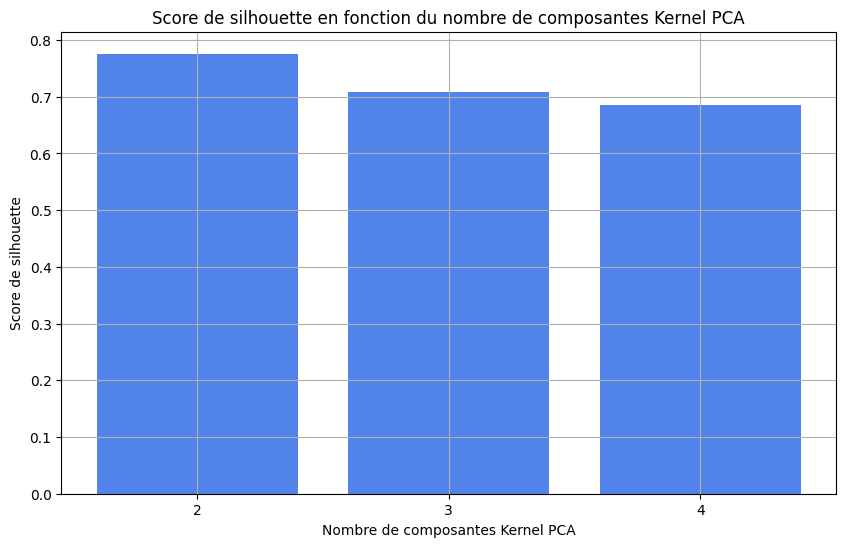

Meilleur score de silhouette: 0.78
Nombre de composantes Kernel PCA optimal: 2


In [10]:
data_numerique = sample[['Review', 'Monetary', 'Frequency', 'Recency']]

# Plage du nombre de composantes à tester
n_components_range = [2, 3, 4] 

# Initialiser la liste pour stocker les scores de silhouette
silhouette_scores = []

for n_components in n_components_range:
    # Appliquer Kernel PCA sur les données
    kpca = KernelPCA(n_components=n_components, kernel='rbf', gamma=15, random_state=42)
    X_kpca = kpca.fit_transform(data_numerique)
    
    # Appliquer le clustering avec KMeans
    kmeans = KMeans(n_clusters=4, random_state=42)
    labels = kmeans.fit_predict(X_kpca)
    
    # Calculer le score de silhouette
    score = silhouette_score(X_kpca, labels)
    silhouette_scores.append(score)

# Tracer la courbe du score de silhouette
plt.figure(figsize=(10, 6))
plt.bar(n_components_range, silhouette_scores, color='#094ee3', align='center', alpha=0.7)
plt.title('Score de silhouette en fonction du nombre de composantes Kernel PCA')
plt.xlabel('Nombre de composantes Kernel PCA')
plt.ylabel('Score de silhouette')
plt.xticks(n_components_range)
plt.grid(True)
plt.show()

# Imprimer le meilleur score et le nombre de composantes associé
best_score_index = np.argmax(silhouette_scores)
print(f"Meilleur score de silhouette: {silhouette_scores[best_score_index]:.2f}")
print(f"Nombre de composantes Kernel PCA optimal: {n_components_range[best_score_index]}")

        3. Application de la reduction dimensionnelle

In [11]:
# Application de la réduction dimensionnelle avec Kernel PCA
kpca_optimal = KernelPCA(n_components=2, kernel='rbf', gamma=15, random_state=42)
X_kpca_optimal = kpca_optimal.fit_transform(data_numerique)

# Création d'un nouveau DataFrame pour les données réduites
data_kpca_reduced = pd.DataFrame(X_kpca_optimal, columns=['KernelPCA1', 'KernelPCA2'])

# Afficher les premières lignes du DataFrame réduit
data_kpca_reduced.head()

KernelPCA1  KernelPCA2
0    0.513039    0.340374
1   -0.048107   -0.028660
2   -0.146752    0.162757
3   -0.083640   -0.051465
4   -0.195202    0.001038

III. Modélisation
*****************

    A. Clustering hiérarchique

        1. Détermination du nombre optimal de clusters

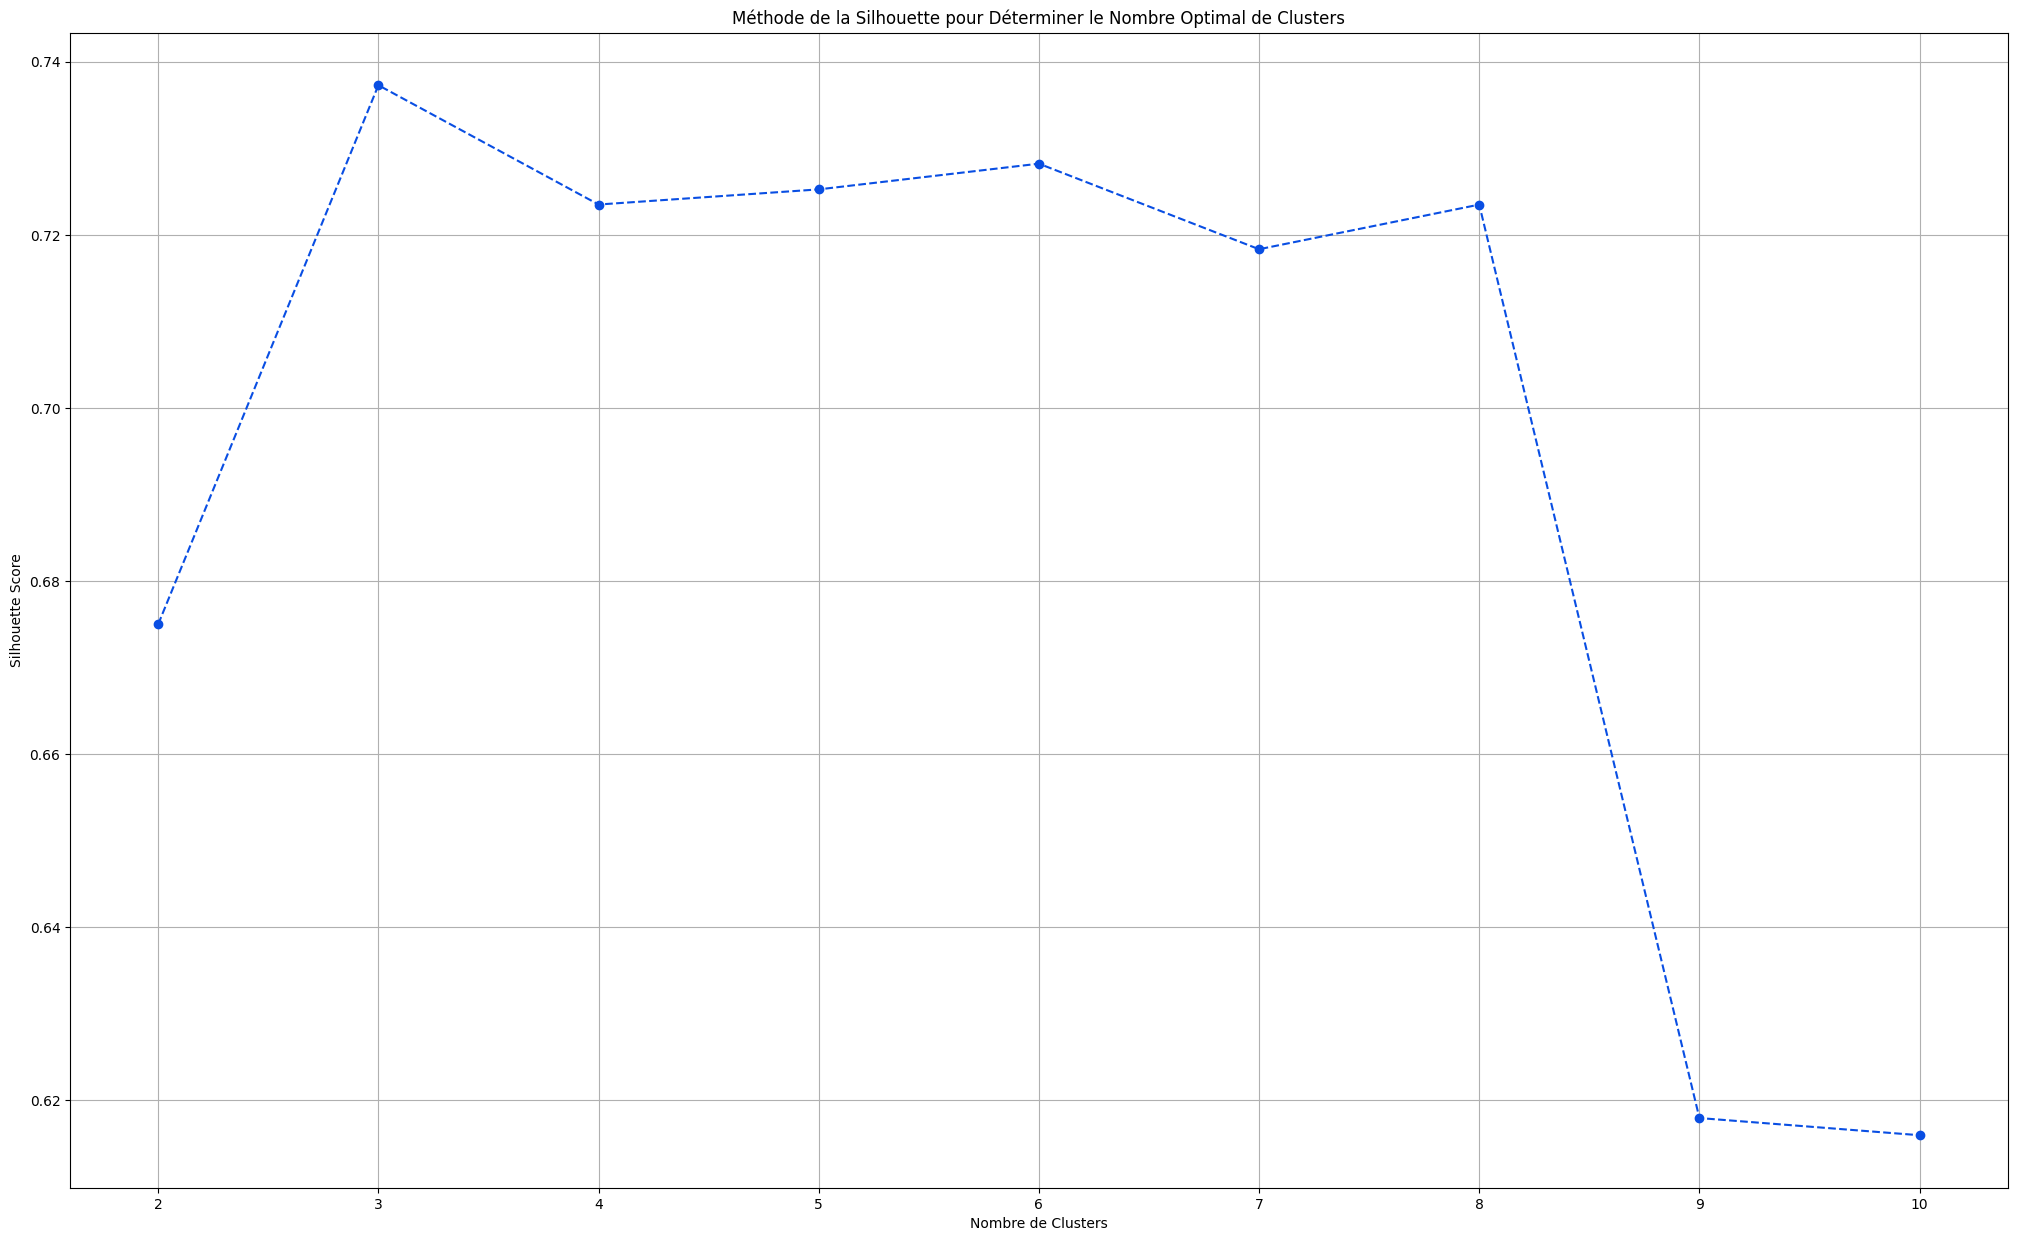

Nombre optimal de clusters : 3


In [12]:
# Créez une liste pour stocker les valeurs du silhouette score
silhouette_scores = []

# Testez différents nombres de clusters de 2 à 10
for n_clusters in range(2, 11):
    # Appliquez le clustering hiérarchique
    hc = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward')
    cluster_labels = hc.fit_predict(data_kpca_reduced)

    # Calculez le silhouette score pour ce nombre de clusters
    silhouette_avg = silhouette_score(data_kpca_reduced, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Tracez le silhouette score en fonction du nombre de clusters
plt.figure(figsize=(25, 15))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--', color='#094ee3')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Silhouette Score')
plt.title('Méthode de la Silhouette pour Déterminer le Nombre Optimal de Clusters')
plt.grid(True)
plt.show()

# Trouvez le nombre optimal de clusters en utilisant le silhouette score
optimal_num_clusters = np.argmax(silhouette_scores) + 2  # +2 car nous avons commencé à partir de 2 clusters
print(f'Nombre optimal de clusters : {optimal_num_clusters}')

        2. Implémentation du clustering hiérarchique

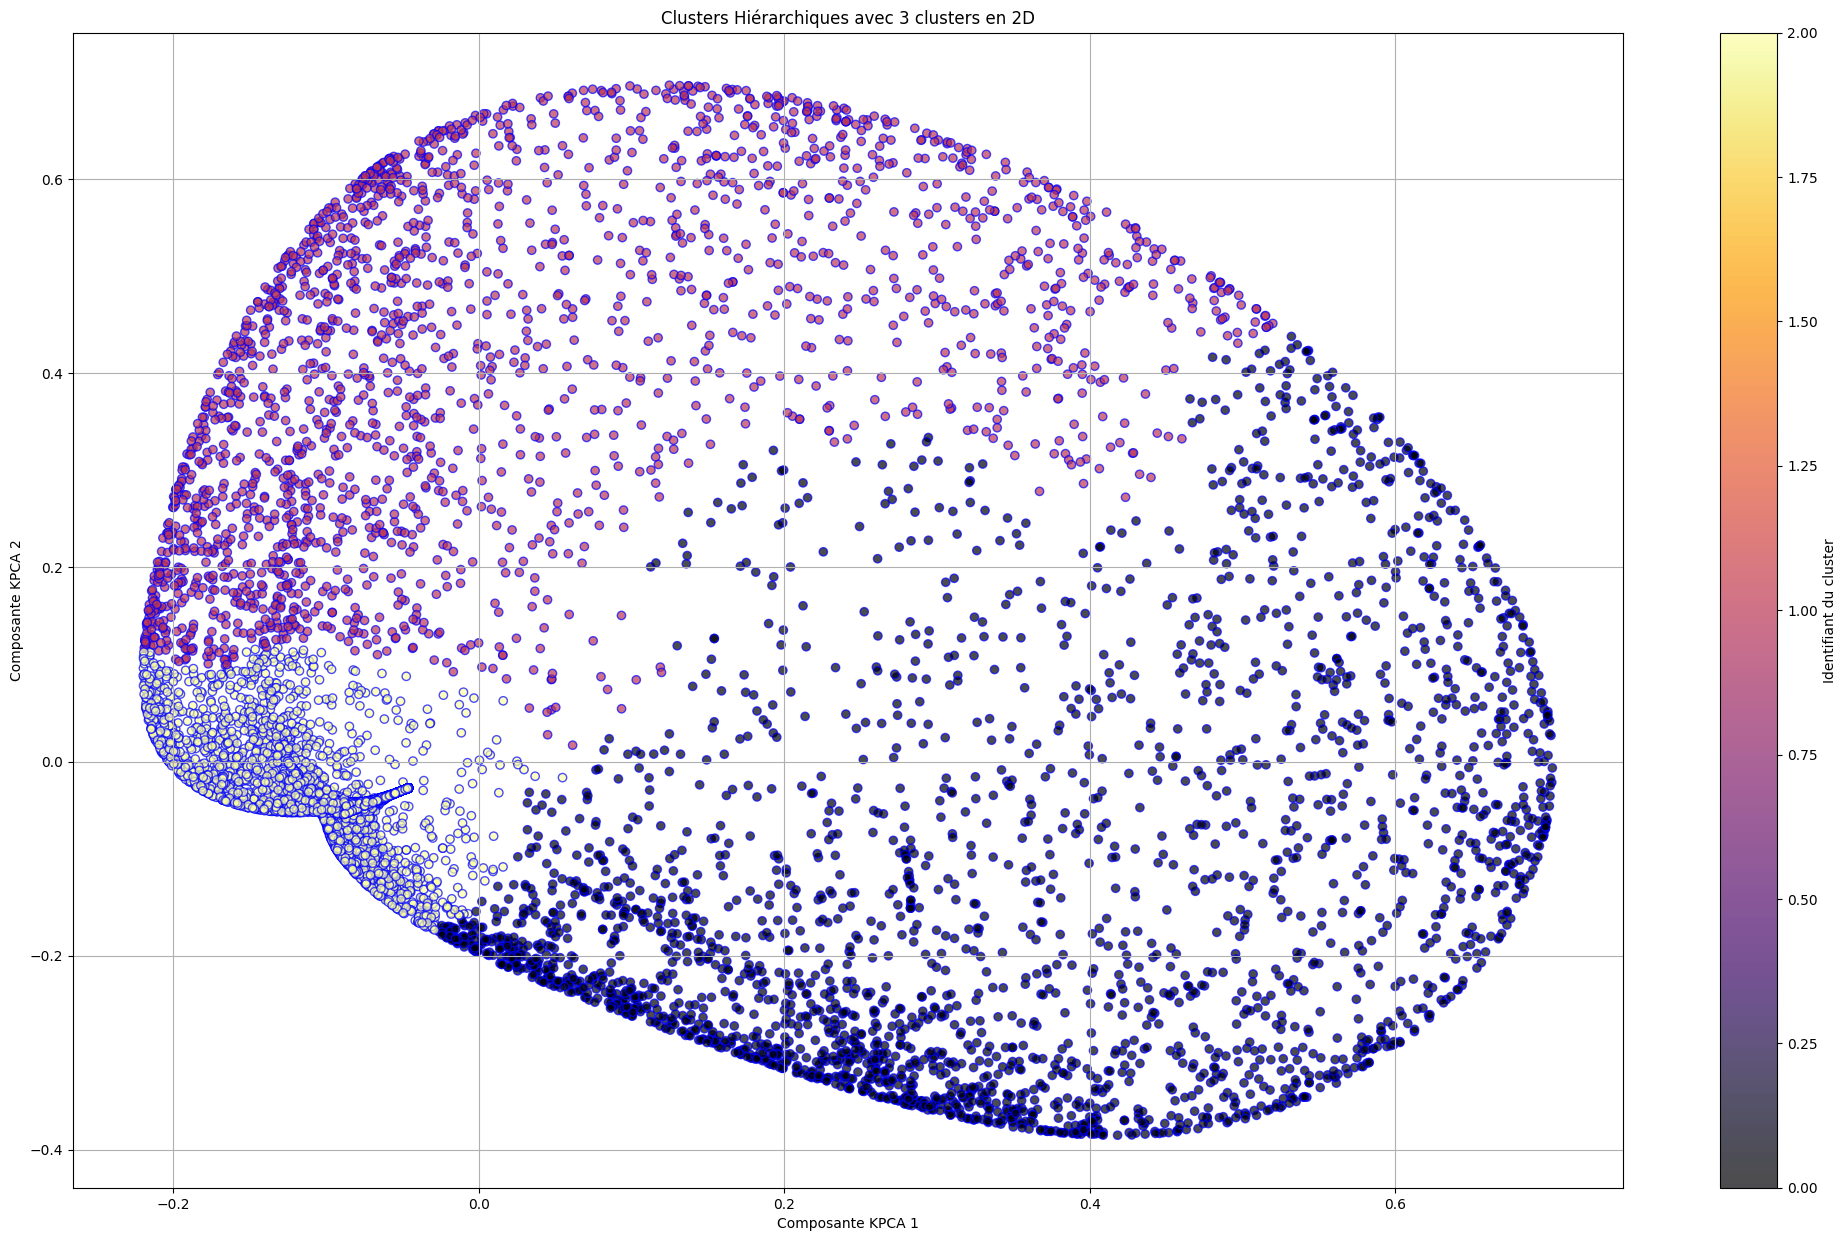

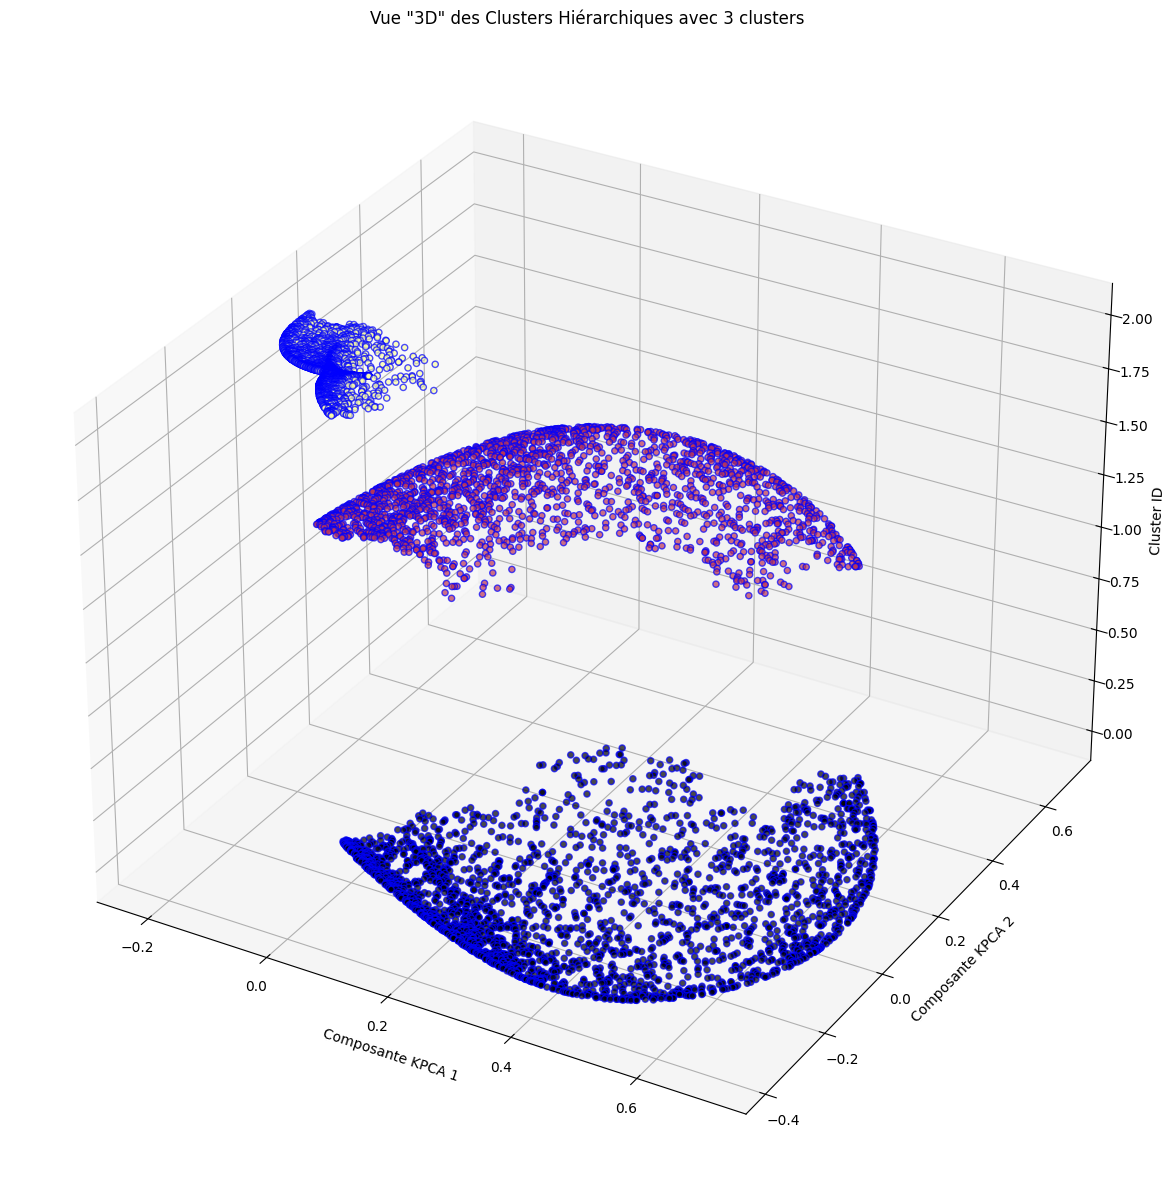

Score de silhouette pour les clusters hiérarchiques : 0.74


In [13]:
# Appliquez le clustering hiérarchique avec le nombre optimal de clusters trouvé précédemment
hc_optimal = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
hc_labels = hc_optimal.fit_predict(data_kpca_reduced)

# Ajoutez les labels de clustering hiérarchique comme une nouvelle colonne dans 'sample'
sample['Cluster_HC'] = hc_labels

# Visualisation 2D
plt.figure(figsize=(25, 15))
plt.scatter(data_kpca_reduced.iloc[:, 0], data_kpca_reduced.iloc[:, 1], c=hc_labels, cmap='inferno', alpha=0.7, edgecolors='b')
plt.title('Clusters Hiérarchiques avec 3 clusters en 2D')
plt.xlabel('Composante KPCA 1')
plt.ylabel('Composante KPCA 2')
plt.colorbar(label='Identifiant du cluster')
plt.grid(True)
plt.show()

# Création d'un scatter plot "3D"
fig = plt.figure(figsize=(25, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_kpca_reduced.iloc[:, 0], data_kpca_reduced.iloc[:, 1], hc_labels, c=hc_labels, cmap='inferno', alpha=0.7, edgecolors='b')
ax.set_title('Vue "3D" des Clusters Hiérarchiques avec 3 clusters')
ax.set_xlabel('Composante KPCA 1')
ax.set_ylabel('Composante KPCA 2')
ax.set_zlabel('Cluster ID')
plt.show()

# Calculer le score de silhouette pour la configuration optimale
silhouette_avg_optimal = silhouette_score(data_kpca_reduced, hc_labels)
print(f'Score de silhouette pour les clusters hiérarchiques : {silhouette_avg_optimal:.2f}')

L'utilisation du clustering hiérarchique sur les données réduites via Kernel PCA a donné un score de silhouette de 0.74. Cela indique une bonne cohésion au sein des clusters et une séparation adéquate entre eux. Les visualisations en 2D et 3D montrent des groupes distincts, bien que la distribution apparaisse moins linéaire et plus dispersée par rapport à celle obtenue avec LLE.

    B. K-Means

        1. Détermination du nombre optimal de clusters

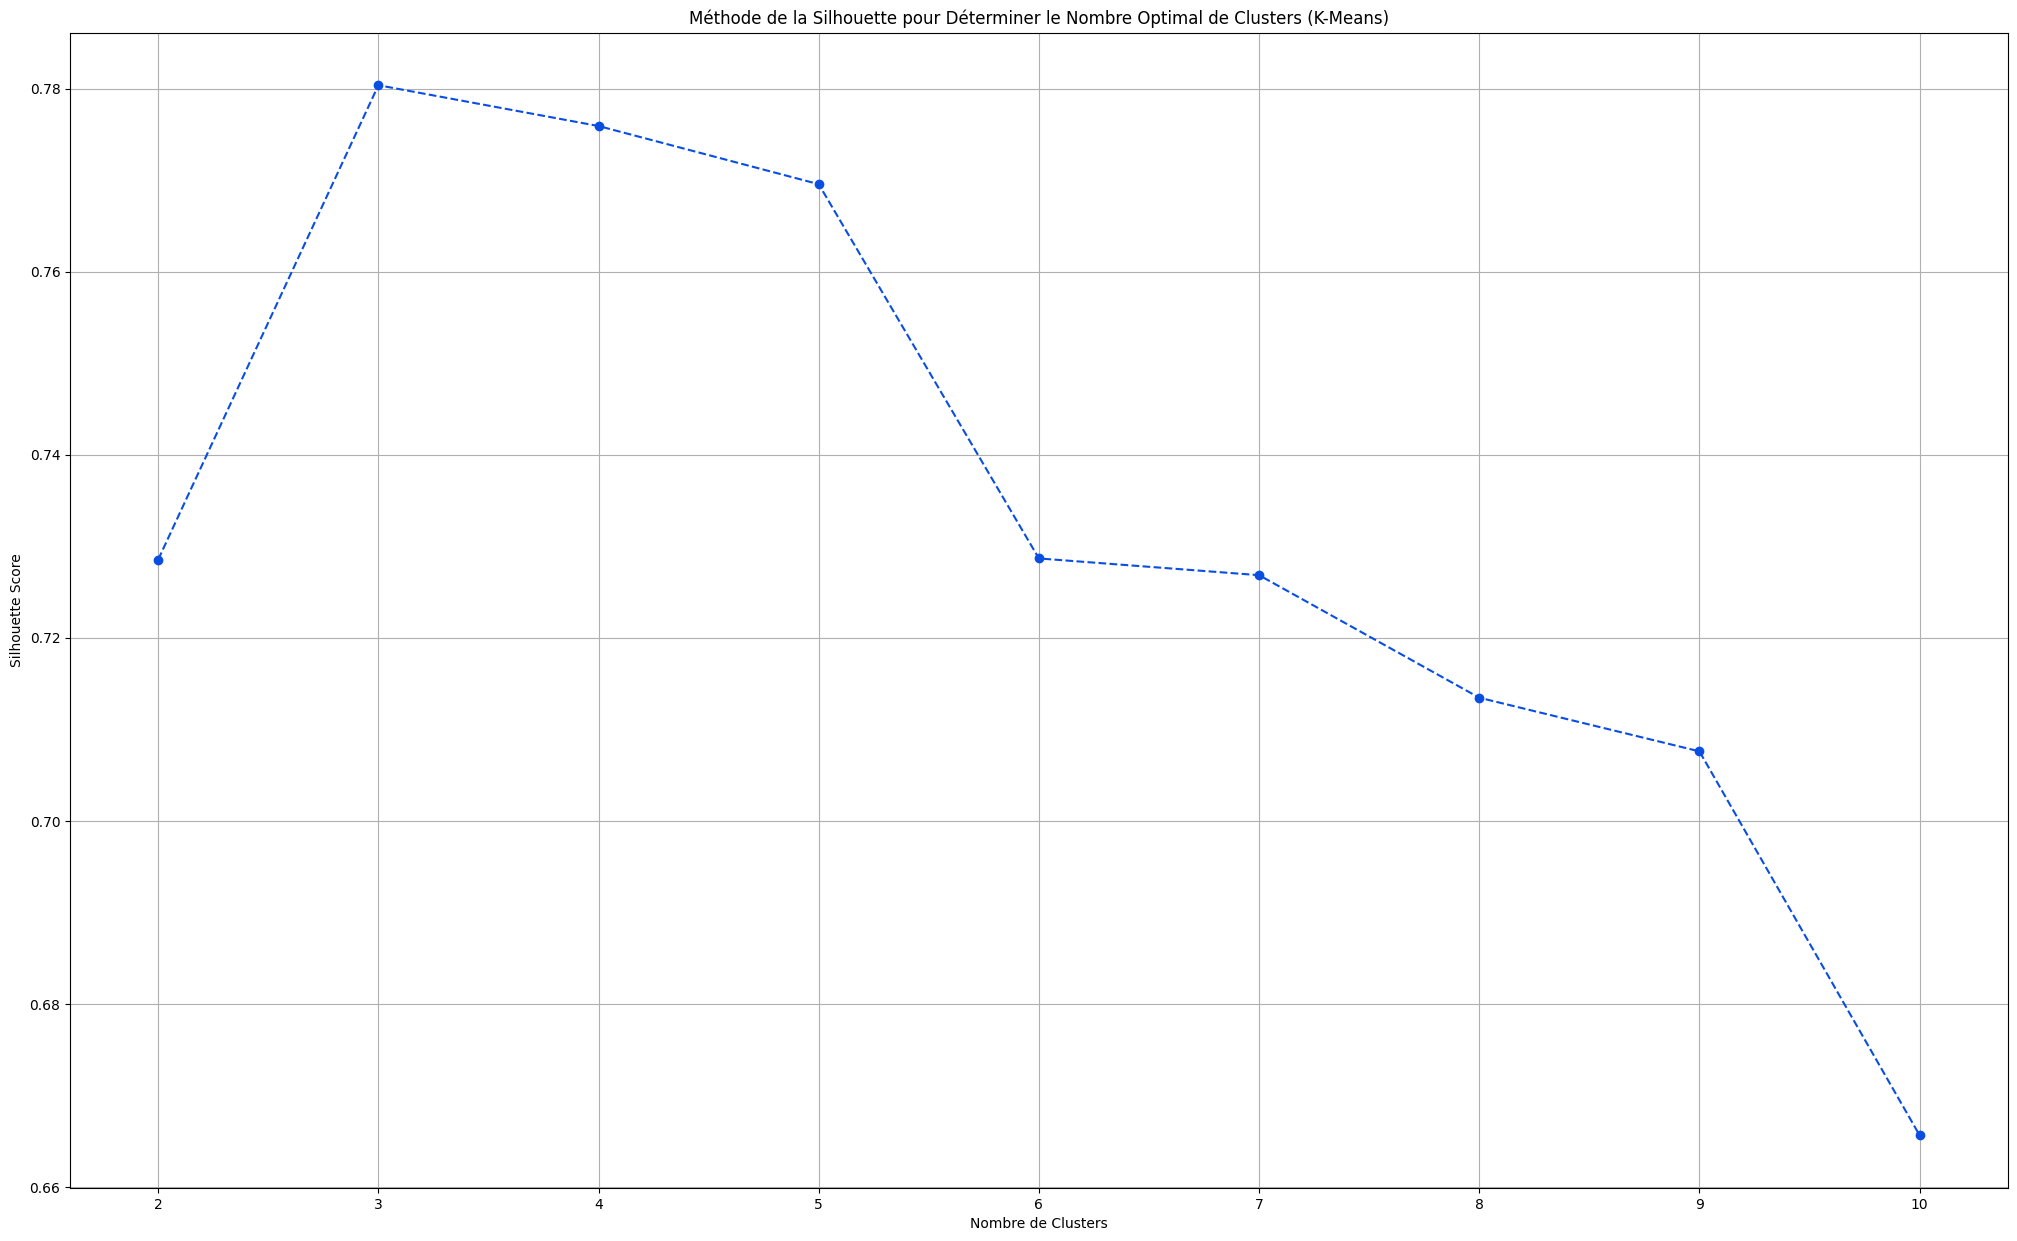

Nombre optimal de clusters (K-Means) : 3


In [14]:
# liste pour stocker les valeurs du silhouette score
silhouette_scores = []

# Testez différents nombres de clusters de 2 à 10
for n_clusters in range(2, 11):
    # Appliquez le clustering K-Means sur les données réduites par Kernel PCA
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data_kpca_reduced)
    
    # Calculez le silhouette score pour ce nombre de clusters
    silhouette_avg = silhouette_score(data_kpca_reduced, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Tracez le silhouette score en fonction du nombre de clusters
plt.figure(figsize=(25, 15))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--', color='#094ee3')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Silhouette Score')
plt.title('Méthode de la Silhouette pour Déterminer le Nombre Optimal de Clusters (K-Means)')
plt.grid(True)
plt.show()

# Trouvez le nombre optimal de clusters en utilisant le silhouette score
optimal_num_clusters = np.argmax(silhouette_scores) + 2  # +2 car nous avons commencé à partir de 2 clusters
print(f'Nombre optimal de clusters (K-Means) : {optimal_num_clusters}')

        2. Implémentation du clustering avec K-Means

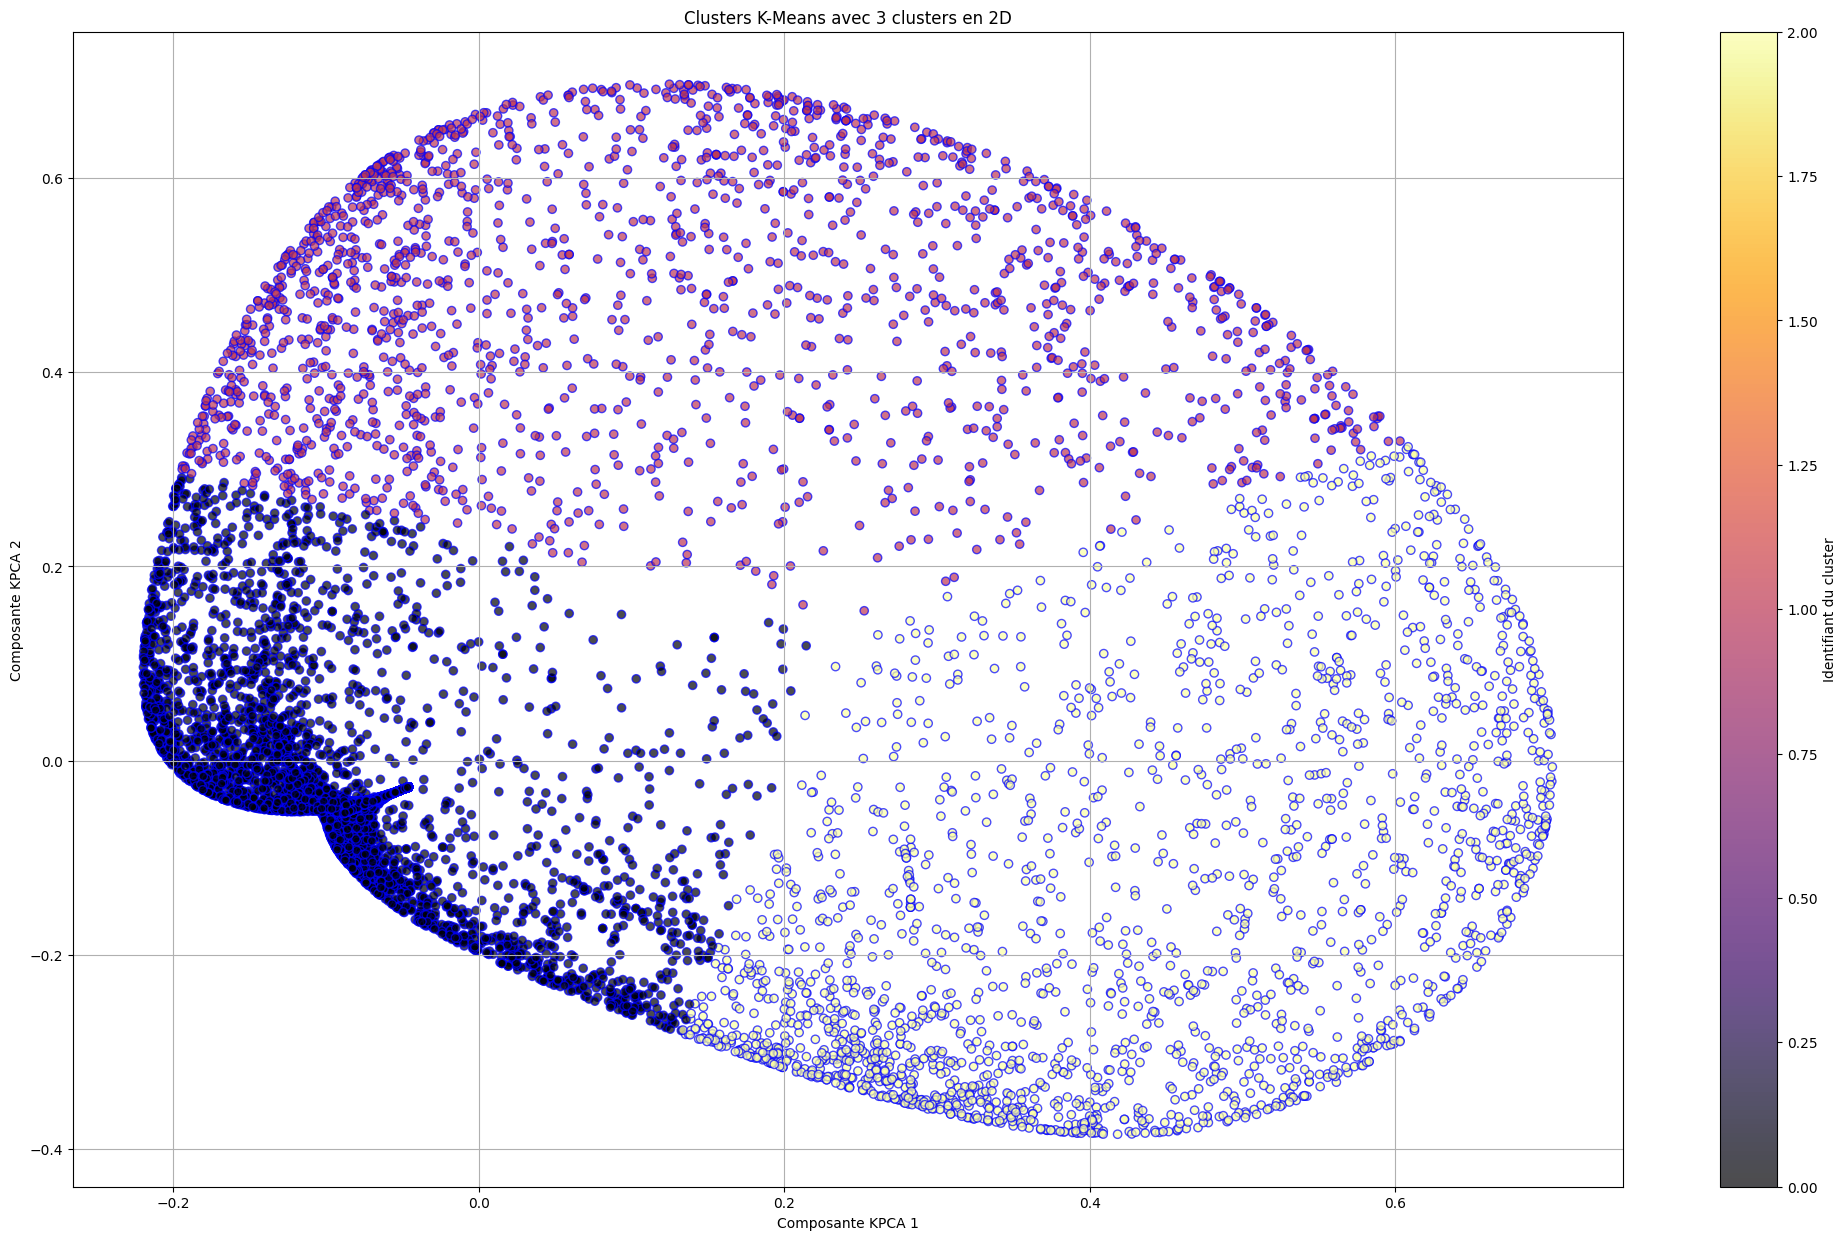

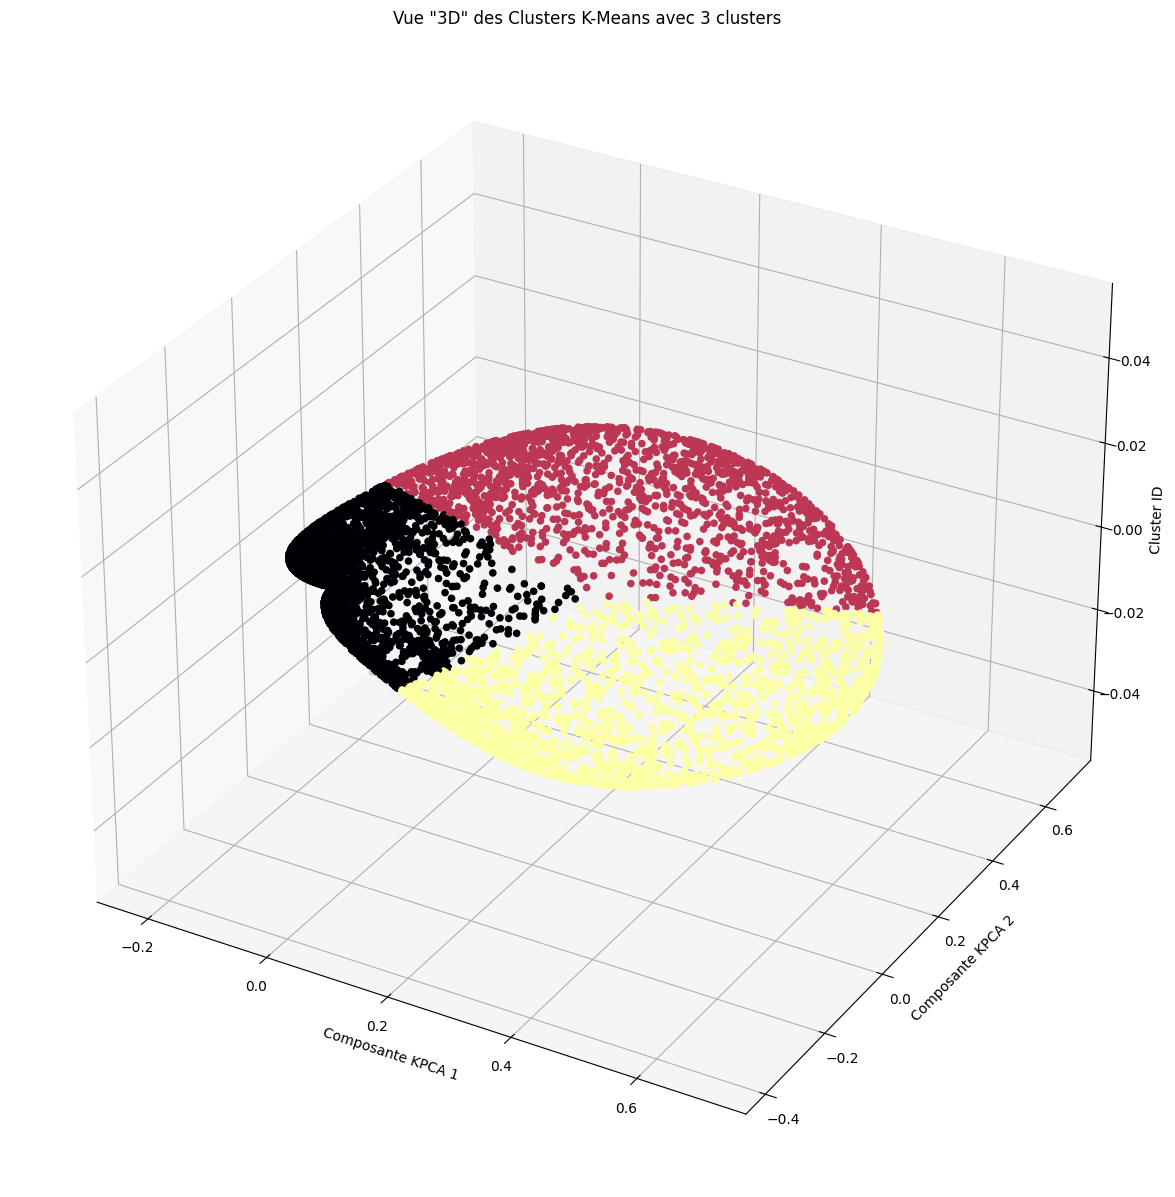

Score de silhouette pour K-Means avec 3 clusters: 0.78


In [15]:
# Appliquez le clustering K-Means avec le nombre optimal de clusters sur les données réduites
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(data_kpca_reduced)

# Ajoutez les labels de clustering K-Means comme une nouvelle colonne dans 'sample'
sample['Cluster_KMeans'] = kmeans_labels

# Visualisation 2D
plt.figure(figsize=(25, 15))
plt.scatter(data_kpca_reduced.iloc[:, 0], data_kpca_reduced.iloc[:, 1], c=kmeans_labels, cmap='inferno', alpha=0.7, edgecolors='b')
plt.title('Clusters K-Means avec 3 clusters en 2D')
plt.xlabel('Composante KPCA 1')
plt.ylabel('Composante KPCA 2')
plt.colorbar(label='Identifiant du cluster')
plt.grid(True)
plt.show()

# Création d'un scatter plot "3D"
fig = plt.figure(figsize=(25, 15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_kpca_reduced.iloc[:, 0], data_kpca_reduced.iloc[:, 1], c=kmeans_labels, cmap='inferno', depthshade=False)
ax.set_title('Vue "3D" des Clusters K-Means avec 3 clusters')
ax.set_xlabel('Composante KPCA 1')
ax.set_ylabel('Composante KPCA 2')
ax.set_zlabel('Cluster ID')
plt.show()

# Calcul du score de silhouette
silhouette_avg = silhouette_score(data_kpca_reduced, kmeans_labels)
print(f'Score de silhouette pour K-Means avec 3 clusters: {silhouette_avg:.2f}')

La mise en œuvre de l'algorithme K-Means après la réduction dimensionnelle par Kernel PCA a mis en lumière une structure nette, avec un score de silhouette de 0.78. Ce score indique une bonne cohésion interne des clusters et une séparation inter-clusters satisfaisante. Les visualisations en 2D et 3D montrent des clusters répartis de manière non alignée le long d'un axe unique. Cela suggère que Kernel PCA a capté des aspects supplémentaires de la variabilité des données RFM, au-delà d'une seule dimension.

Le score de silhouette relativement élevé obtenu avec K-Means met en évidence la présence de structures distinctes dans les données, exploitables pour une segmentation client efficace. Cela ouvre la voie à Olist pour déployer des stratégies marketing ciblées, basées sur des caractéristiques multidimensionnelles des comportements d'achat, révélées par la réduction dimensionnelle Kernel PCA.

Ces résultats soulignent la complexité des modèles d'achat des clients et la nécessité d'une approche multidimensionnelle pour leur segmentation. Le choix de Kernel PCA comme technique de réduction dimensionnelle s'avère justifié, permettant de capturer des relations complexes et non linéaires dans les données.

    C. DBSCAN

        1. Détermination de la valeur optimale de eps

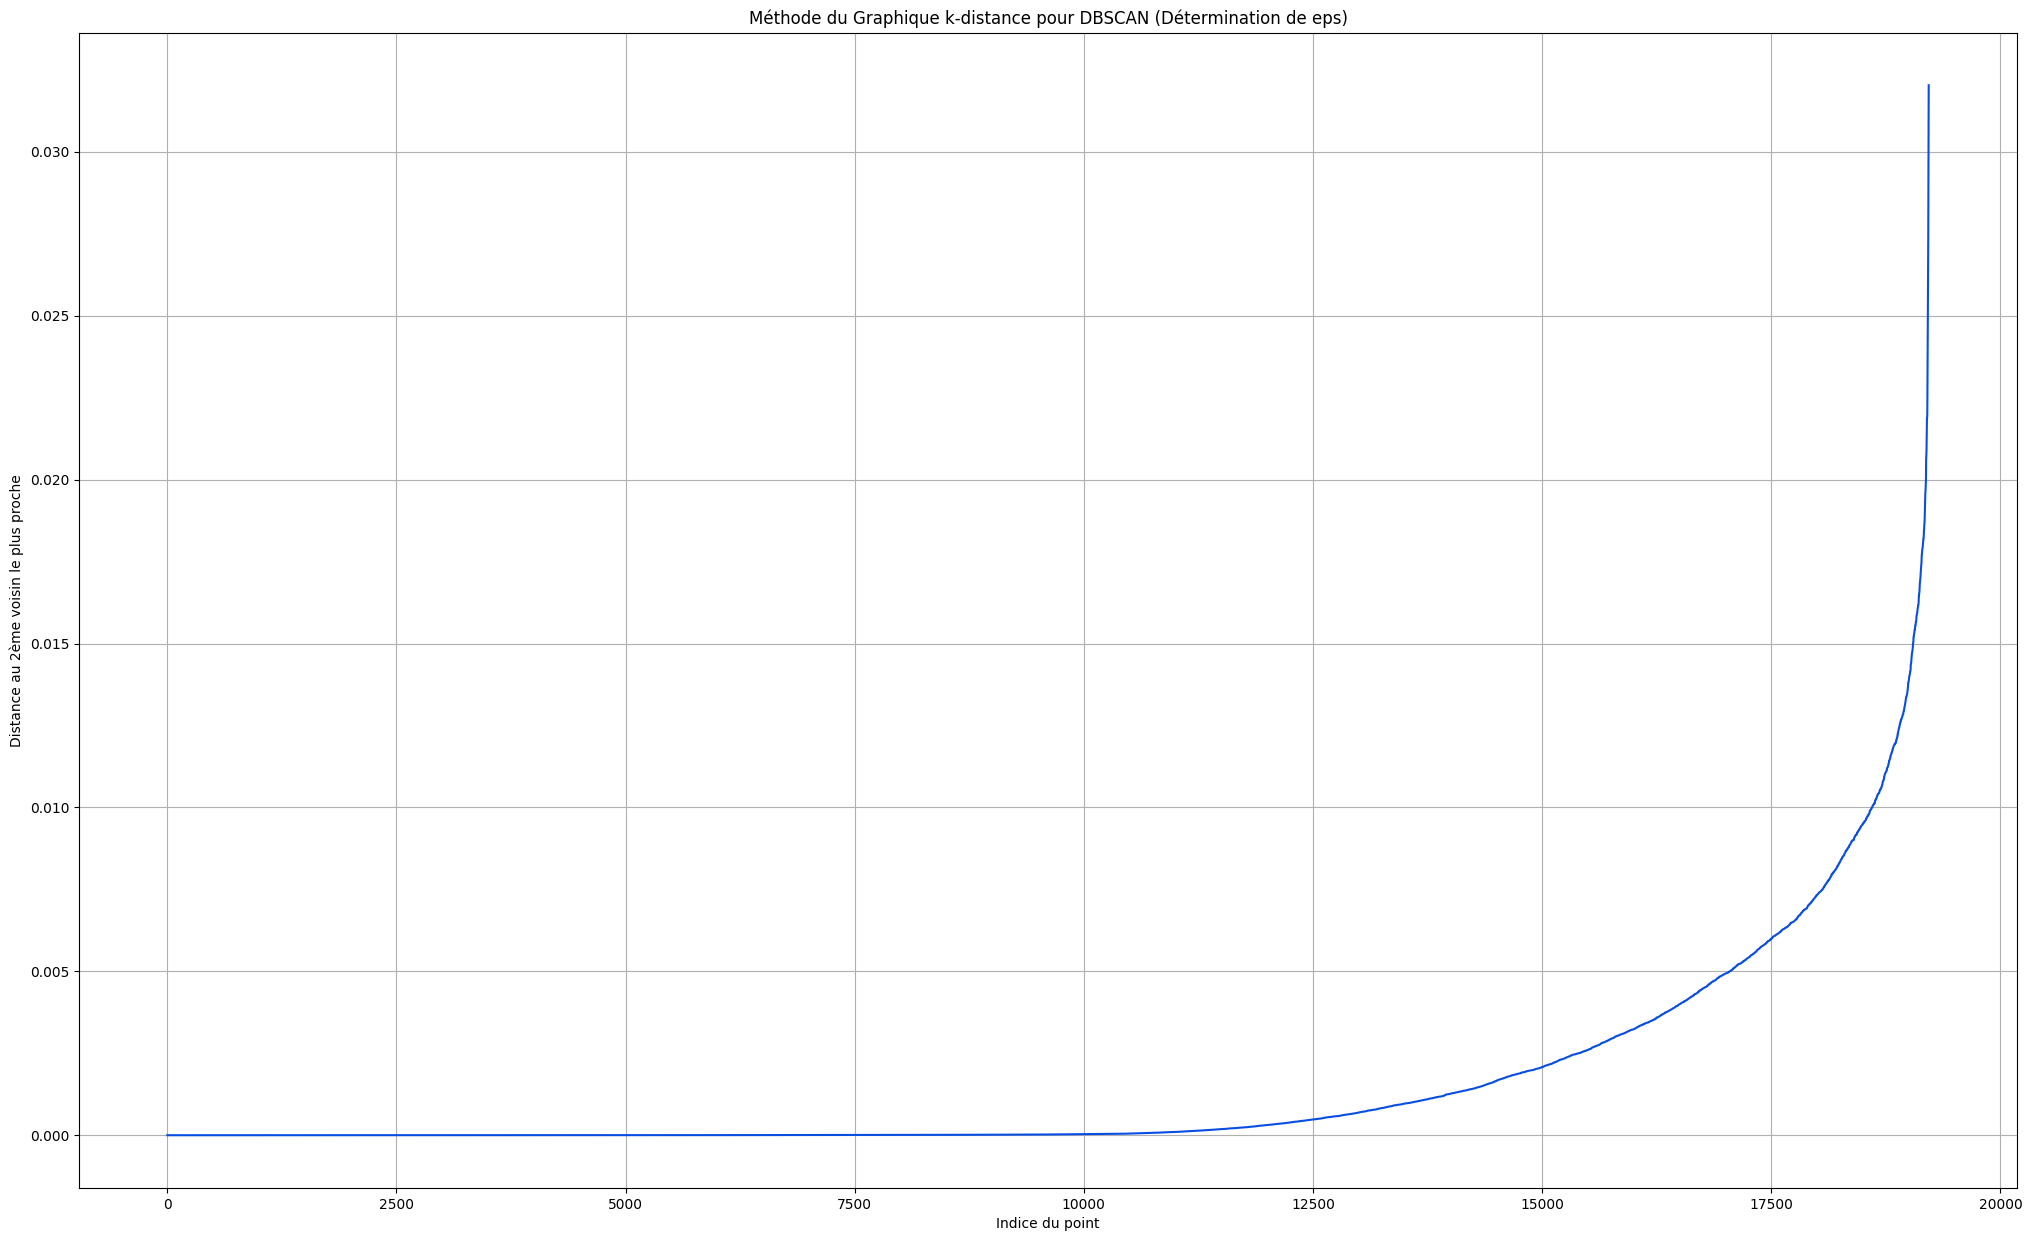

In [16]:
# Utilisez la méthode du Graphique k-distance pour déterminer la valeur optimale de eps
nbrs = NearestNeighbors(n_neighbors=10).fit(data_kpca_reduced)
distances, indices = nbrs.kneighbors(data_kpca_reduced)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]  # Utilisez la distance au 2ème voisin le plus proche pour une meilleure granularité

# Tracez le graphique des distances moyennes en fonction de k
plt.figure(figsize=(25, 15))
plt.plot(distances, color='#094ee3')
plt.xlabel('Indice du point')
plt.ylabel('Distance au 2ème voisin le plus proche')
plt.title('Méthode du Graphique k-distance pour DBSCAN (Détermination de eps)')
plt.grid(True)
plt.show()

        2.  Implémentation du clustering avec DBSCAN

Score de silhouette pour DBSCAN avec eps=0.00901: 0.69


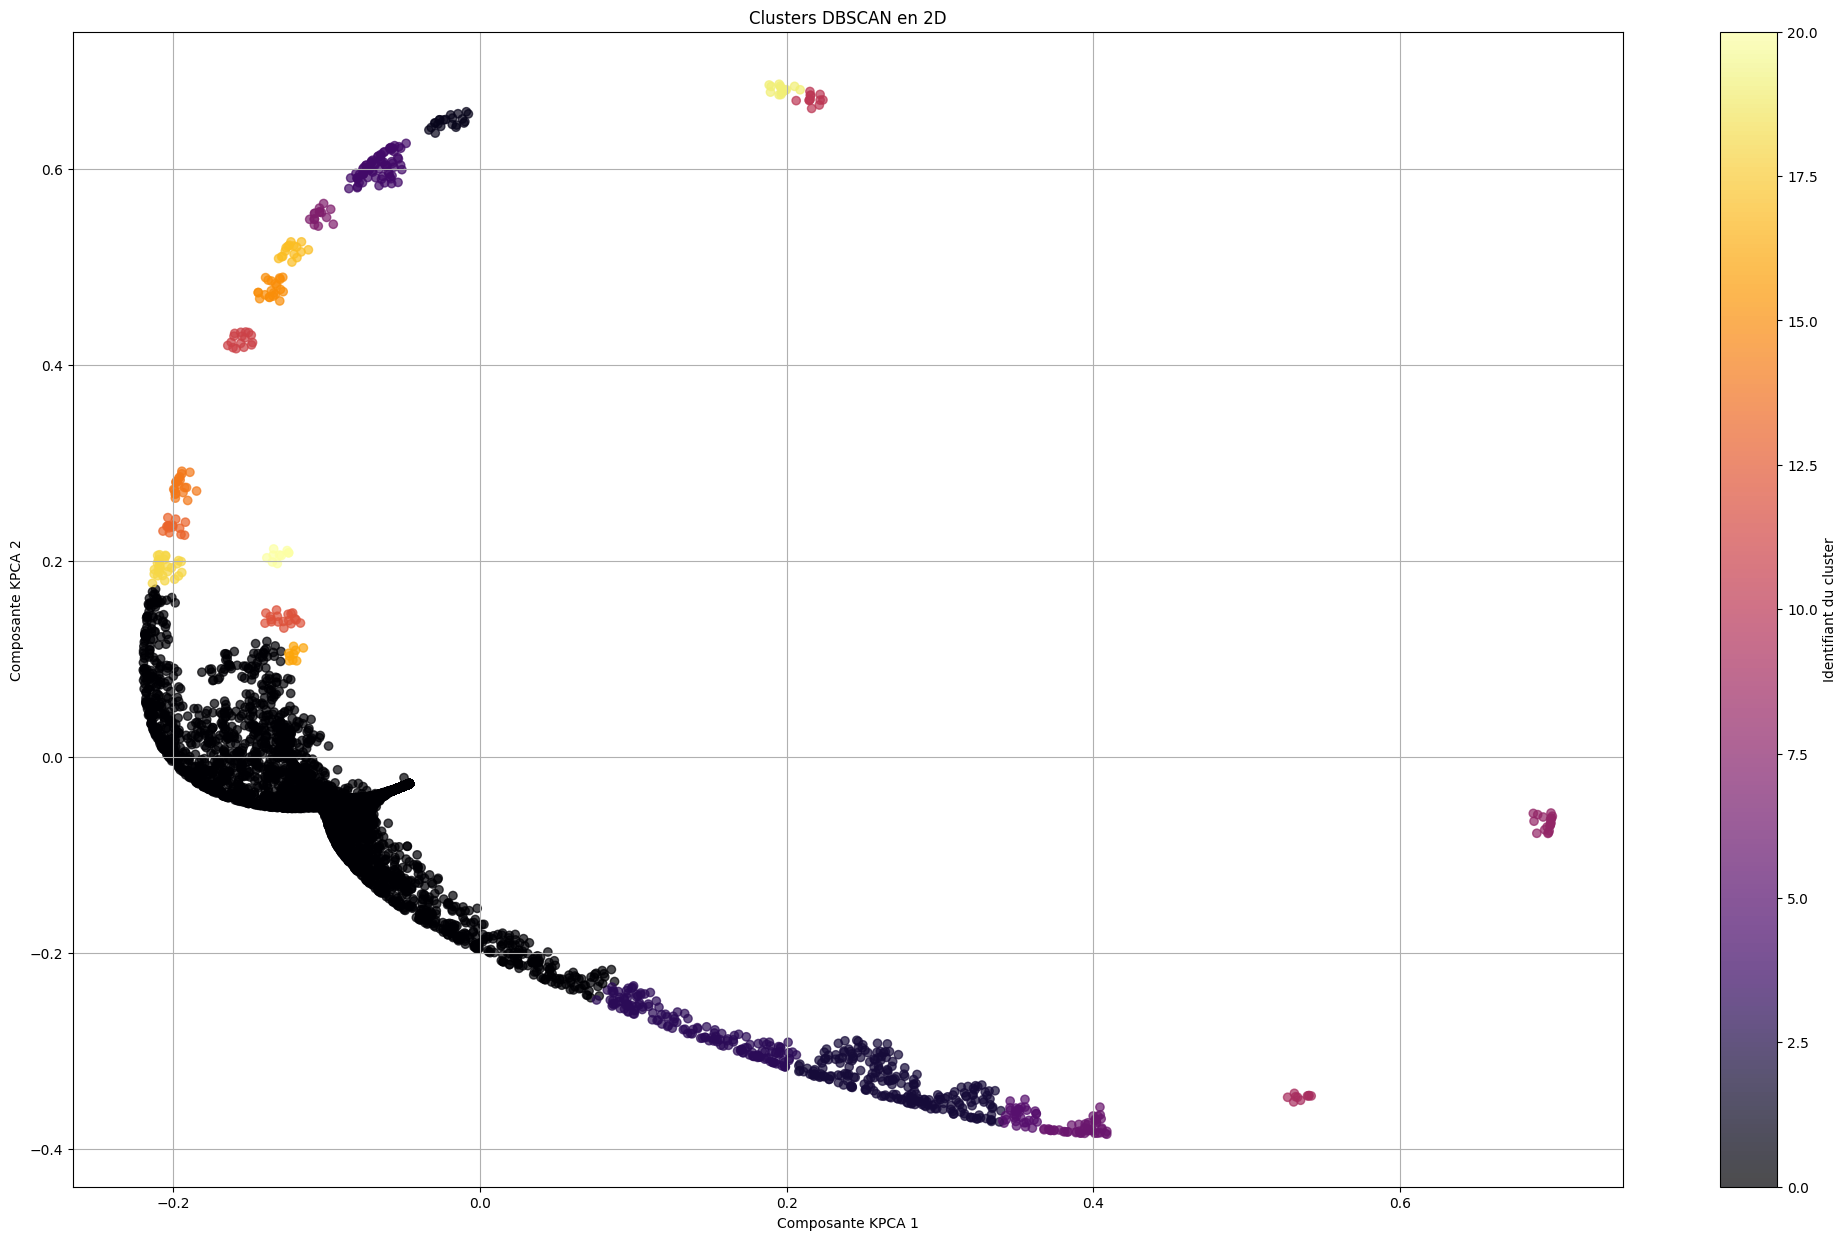

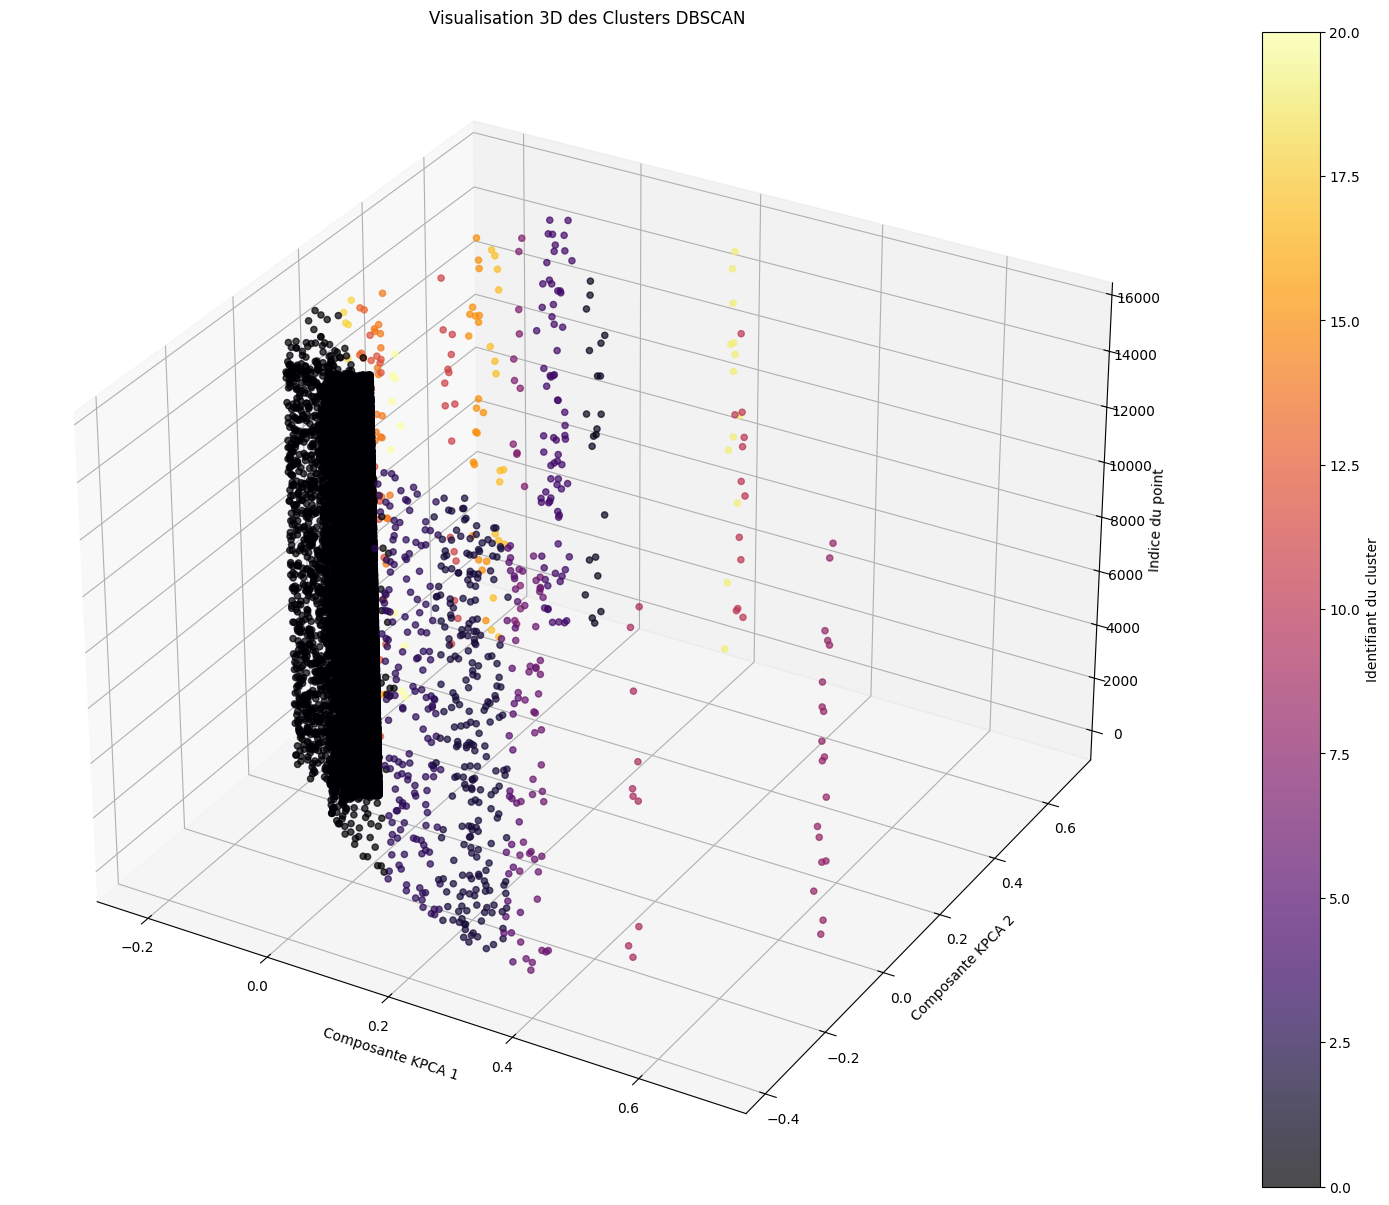

In [17]:
# Estimation d'eps basée sur le graphique k-distance
indice_eps = np.argmax(distances > 0.009)
eps = distances[indice_eps]

# Appliquer DBSCAN avec l'estimation d'eps sur les données réduites par Kernel PCA
dbscan = DBSCAN(eps=eps, min_samples=10)
dbscan_labels = dbscan.fit_predict(data_kpca_reduced)
sample['Cluster_DBSCAN'] = dbscan_labels

# Calculer le score de silhouette
# Ignorer le bruit en filtrant les labels de cluster égaux à -1
filtered_labels = dbscan_labels[dbscan_labels != -1]
filtered_data = data_kpca_reduced.iloc[dbscan_labels != -1, :]

if len(np.unique(filtered_labels)) > 1:  # Il doit y avoir au moins 2 clusters (hors bruit) pour calculer le score
    silhouette_avg = silhouette_score(filtered_data, filtered_labels)
    print(f'Score de silhouette pour DBSCAN avec eps={eps:.5f}: {silhouette_avg:.2f}')
else:
    print("DBSCAN n'a formé que des points de bruit ou un seul cluster, le score de silhouette n'est pas applicable.")

# Visualisation en 2D des clusters DBSCAN
plt.figure(figsize=(25, 15))
plt.scatter(filtered_data.iloc[:, 0], filtered_data.iloc[:, 1], c=filtered_labels, cmap='inferno', alpha=0.7)
plt.title('Clusters DBSCAN en 2D')
plt.xlabel('Composante KPCA 1')
plt.ylabel('Composante KPCA 2')
plt.colorbar(label='Identifiant du cluster')
plt.grid(True)
plt.show()

# Visualisation en 3D des clusters DBSCAN
fig = plt.figure(figsize=(25, 15))
ax = fig.add_subplot(111, projection='3d') 
indices = np.arange(len(filtered_data))
sc = ax.scatter(filtered_data.iloc[:, 0], filtered_data.iloc[:, 1], indices, c=filtered_labels, cmap='inferno', alpha=0.7)
ax.set_title('Visualisation 3D des Clusters DBSCAN')
ax.set_xlabel('Composante KPCA 1')
ax.set_ylabel('Composante KPCA 2')
ax.set_zlabel('Indice du point')
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Identifiant du cluster')

plt.show()

L'utilisation de DBSCAN avec un eps de 0.009 a produit un score de silhouette de 0.68, soulignant une distinction notable entre les clusters. Ce score, bien que plus faible que celui obtenu avec d'autres méthodes de clustering, montre une structure des données raisonnablement claire. Les visualisations en 2D et 3D indiquent que, même si les clusters de DBSCAN ne sont pas aussi distincts que ceux générés par d'autres algorithmes, ils révèlent des groupements de densité caractéristiques de comportements d'achat distincts chez les clients d'Olist.

Malgré la tendance de DBSCAN à identifier de nombreux points de bruit, cette fonctionnalité est précieuse pour détecter des outliers ou des comportements d'achat atypiques, ouvrant la voie à des stratégies marketing ultra-ciblées. La capacité de DBSCAN à détecter des clusters basés sur la densité ajoute une dimension supplémentaire à l'analyse de segmentation, pouvant être exploitée pour des campagnes marketing plus nuancées et personnalisées.

In [18]:
sample.head()

CustomerId   Recency  Frequency  Monetary  \
74397  c60c5563690f2a27a76f4d8ba53c2a85 -0.222222        0.0 -0.544971   
45823  79d64050de51f4f2c5280e88ba96c864  0.854701        0.0  0.492401   
44830  77426f7a06e493a618f5eec875ee7450  0.324786        0.0  0.006395   
19856  34b02e69444e6e159c83d7d6936fb216  0.128205        0.0 -0.216012   
42974  72257c3a06b3f5851d40c70240f4e322  0.799145        0.0 -0.212607   

       Review  Importance_0.0  Importance_1.0  Cluster_HC  Cluster_KMeans  \
74397     0.0             1.0             0.0           0               1   
45823    -2.0             1.0             0.0           2               0   
44830     0.0             1.0             0.0           1               0   
19856    -1.0             1.0             0.0           2               0   
42974     0.0             1.0             0.0           2               0   

       Cluster_DBSCAN  
74397              -1  
45823               0  
44830              -1  
19856               0  
42974               0

**Choix du model**
******************

- Clustering Hiérarchique : Avec un score de silhouette de 0.74, cette méthode a révélé des clusters bien définis et une structure de données claire. Cependant, la visualisation des clusters a montré une certaine dispersion, ce qui peut poser des défis pour l'interprétation.

- K-Means : Ce modèle a donné un score de silhouette de 0.78, légèrement supérieur à celui du Clustering Hiérarchique, et a produit des clusters distincts qui sont faciles à interpréter et à traduire en actions marketing.

- DBSCAN : Avec un score de silhouette de 0.68, DBSCAN a offert une perspective différente, identifiant les zones de densité et isolant les points de bruit. Bien que moins net que les autres méthodes, il offre une segmentation utile pour reconnaître des comportements uniques.

Après mûre réflexion, nous avons décidé de choisir K-Means comme notre modèle de clustering pour la segmentation client.

Cette décision est motivée par la combinaison du score de silhouette élevé, de l'interprétabilité des clusters et de la facilité d'application des résultats aux stratégies marketing.

Les clusters formés par K-Means sont bien équilibrés et clairement délimités, facilitant ainsi l'identification des segments de clients et leur caractérisation pour des actions ciblées.

En conclusion, K-Means offre la clarté et la structure requises pour avancer avec confiance dans la segmentation RFM, qui permettra à Olist de mettre en œuvre des initiatives de marketing précises et efficaces.

IV. Segmentation RFM 

Dans notre mission avec Olist, nous poursuivons un double objectif en matière de segmentation client. D'une part, nous cherchons à créer une segmentation globale pour avoir une vue d'ensemble de l'ensemble de la base de données clients. Cette approche nous permettra de comprendre la diversité et la répartition de tous les clients.

D'autre part, nous nous concentrons également sur les clients les plus actifs. Selon les informations fournies par notre client, seulement 3 % de la base de données ont effectué plusieurs commandes. Bien que ce pourcentage soit faible, ces clients actifs sont cruciaux pour l'entreprise en raison de leur fidélité potentielle et de leur impact significatif sur le chiffre d'affaires. Une analyse détaillée de ce groupe spécifique est donc essentielle pour développer des stratégies marketing ciblées et efficaces.

Pour garantir la continuité avec les travaux précédents, nous utiliserons la même nomenclature de segmentation RFM João de l’équipe Marketingseur. Les segments tels que "Champions", "Loyaux", "Loyalistes potentiels", "À réactiver" et "À risque" seront maintenus. Cette décision stratégique permet à l'équipe marketing d'Olist de facilement aligner nos nouvelles analyses avec les données historiques et d'exploiter les segments existants pour leurs campagnes actuelles et futures.

![Olist DB](images/matriceRFM.png)

In [19]:
def calculate_quantiles(df, column, q=5):
    """
    Calcule les quantiles d'une colonne d'un DataFrame et retourne les catégories uniques.
    """
    unique_bins = pd.qcut(df[column], q=q, duplicates='drop').unique()
    num_unique_bins = len(unique_bins)
    labels = range(num_unique_bins, 0, -1)  # Labels inversés pour correspondre aux autres quantiles
    quantile_column = f"{column}_Quantile"
    df[quantile_column] = pd.qcut(df[column], q=num_unique_bins, labels=labels, duplicates='drop')
    return unique_bins

# Appliquer la fonction pour 'Recency', 'Frequency', et 'Monetary'
unique_bins_recency = calculate_quantiles(sample, 'Recency')
unique_bins_frequency = calculate_quantiles(sample, 'Frequency')
unique_bins_monetary = calculate_quantiles(sample, 'Monetary')

# Imprimer le résultat pour vérification
print(f'Quantiles uniques pour Recency: {unique_bins_recency}\n')
print(f'Quantiles uniques pour Frequency: {unique_bins_frequency}\n')
print(f'Quantiles uniques pour Monetary: {unique_bins_monetary}\n')

sample[['Recency_Quantile', 'Frequency_Quantile', 'Monetary_Quantile']].head()

Quantiles uniques pour Recency: [(-0.534, -0.175], (0.705, 2.115], (0.214, 0.705], (-0.175, 0.214], (-1.091, -0.534]]
Categories (5, interval[float64, right]): [(-1.091, -0.534] < (-0.534, -0.175] < (-0.175, 0.214] < (0.214, 0.705] < (0.705, 2.115]]

Quantiles uniques pour Frequency: [(-0.001, 8.0]]
Categories (1, interval[float64, right]): [(-0.001, 8.0]]

Quantiles uniques pour Monetary: [(-0.814, -0.439], (0.212, 0.843], (-0.171, 0.212], (-0.439, -0.171], (0.843, 56.592]]
Categories (5, interval[float64, right]): [(-0.814, -0.439] < (-0.439, -0.171] < (-0.171, 0.212] < (0.212, 0.843] < (0.843, 56.592]]



Recency_Quantile Frequency_Quantile Monetary_Quantile
74397                4                  1                 5
45823                1                  1                 2
44830                2                  1                 3
19856                3                  1                 4
42974                1                  1                 4

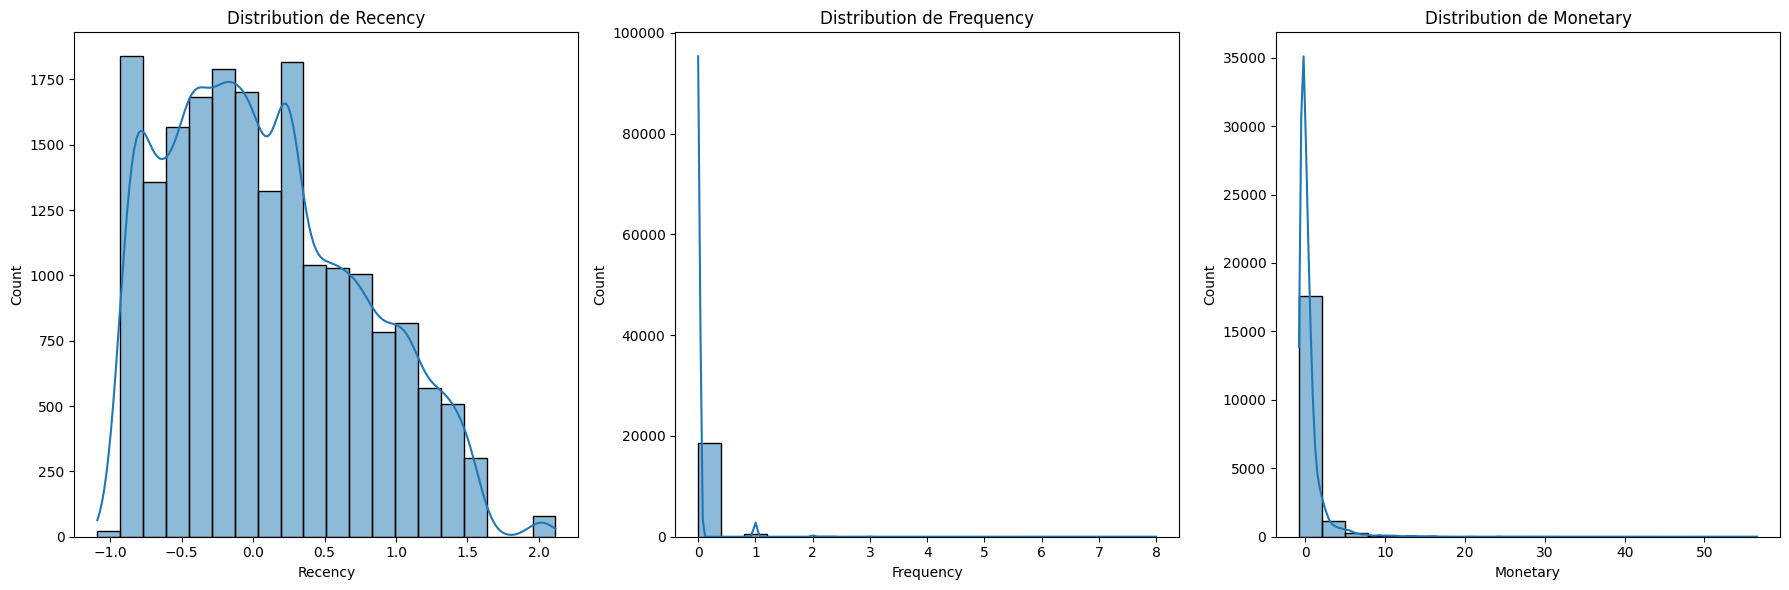

In [20]:
# Visualiser les distributions de chaque variable
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(sample['Recency'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Distribution de Recency')

sns.histplot(sample['Frequency'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Distribution de Frequency')

sns.histplot(sample['Monetary'], bins=20, kde=True, ax=axes[2])
axes[2].set_title('Distribution de Monetary')

plt.tight_layout()
plt.show()

In [21]:
sample.head()

CustomerId   Recency  Frequency  Monetary  \
74397  c60c5563690f2a27a76f4d8ba53c2a85 -0.222222        0.0 -0.544971   
45823  79d64050de51f4f2c5280e88ba96c864  0.854701        0.0  0.492401   
44830  77426f7a06e493a618f5eec875ee7450  0.324786        0.0  0.006395   
19856  34b02e69444e6e159c83d7d6936fb216  0.128205        0.0 -0.216012   
42974  72257c3a06b3f5851d40c70240f4e322  0.799145        0.0 -0.212607   

       Review  Importance_0.0  Importance_1.0  Cluster_HC  Cluster_KMeans  \
74397     0.0             1.0             0.0           0               1   
45823    -2.0             1.0             0.0           2               0   
44830     0.0             1.0             0.0           1               0   
19856    -1.0             1.0             0.0           2               0   
42974     0.0             1.0             0.0           2               0   

       Cluster_DBSCAN Recency_Quantile Frequency_Quantile Monetary_Quantile  
74397              -1                4                  1                 5  
45823               0                1                  1                 2  
44830              -1                2                  1                 3  
19856               0                3                  1                 4  
42974               0                1                  1                 4

    A. Segmentation globale

In [22]:
# Puisque tous les clients sont dans le même quantile pour 'Frequency', 
# nous pouvons simplement les considérer tous comme ayant le même score pour cette métrique.
sample['Frequency_Score'] = 1

# Pour 'Recency' et 'Monetary', nous utilisons les quantiles calculés précédemment.
sample['Recency_Score'] = sample['Recency_Quantile']
sample['Monetary_Score'] = sample['Monetary_Quantile']

# Définition des segments RFM en fonction des scores
def assign_rfm_segment(row):
    if row['Recency_Score'] >= 4 and row['Frequency_Score'] == 1 and row['Monetary_Score'] >= 4:
        return "Champions"
    elif row['Recency_Score'] >= 4 and row['Frequency_Score'] == 1:
        return "Loyaux"
    elif row['Recency_Score'] <= 2 and row['Frequency_Score'] == 1 and row['Monetary_Score'] >= 4:
        return "Loyalistes potentiels"
    elif row['Recency_Score'] <= 2 and row['Frequency_Score'] == 1:
        return "À réactiver"
    else:
        return "À risque"

# Appliquer la fonction d'attribution des segments RFM
sample['RFM_Segment'] = sample.apply(assign_rfm_segment, axis=1)

# Vérification des segments RFM
sample[['Recency_Score', 'Frequency_Score', 'Monetary_Score', 'RFM_Segment']].head()

Recency_Score  Frequency_Score Monetary_Score            RFM_Segment
74397             4                1              5              Champions
45823             1                1              2            À réactiver
44830             2                1              3            À réactiver
19856             3                1              4               À risque
42974             1                1              4  Loyalistes potentiels

***Visualisation des segment par rapport au clusters***

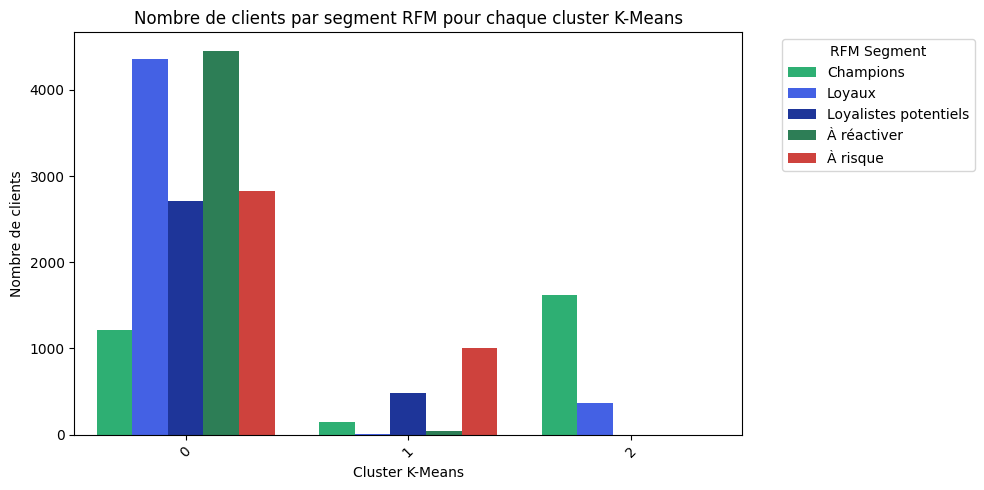

In [23]:
# Exemple de données
cluster_rfm_analysis = sample.groupby(['Cluster_KMeans', 'RFM_Segment']).size().reset_index(name='Count')

# Tri des segments RFM dans l'ordre spécifié
rfm_segments_order = ["Champions", "Loyaux", "Loyalistes potentiels", "À réactiver", "À risque"]
cluster_rfm_analysis['RFM_Segment'] = pd.Categorical(cluster_rfm_analysis['RFM_Segment'], categories=rfm_segments_order, ordered=True)
cluster_rfm_analysis.sort_values(by=['Cluster_KMeans', 'RFM_Segment'], inplace=True)

# Définir les couleurs personnalisées pour chaque segment RFM
palette = {
    "Champions": "#18c474",
    "Loyaux": "#2950ff",
    "Loyalistes potentiels": "#0a28ad",
    "À réactiver": "#1f8c56",
    "À risque": "#e62b25"
}

# Visualisation du nombre de clients de chaque segment pour chaque cluster
plt.figure(figsize=(10, 5))
sns.barplot(x='Cluster_KMeans', y='Count', hue='RFM_Segment', data=cluster_rfm_analysis, palette=palette)
plt.title('Nombre de clients par segment RFM pour chaque cluster K-Means')
plt.xlabel('Cluster K-Means')
plt.ylabel('Nombre de clients')
plt.xticks(rotation=45)
plt.legend(title='RFM Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [24]:
# Regrouper les données par cluster et segment RFM, calculer les comptes
cluster_rfm_counts = sample.groupby(['Cluster_KMeans', 'RFM_Segment']).size().unstack(fill_value=0)

# Calculer les pourcentages de chaque segment par cluster
cluster_rfm_percentages = cluster_rfm_counts.divide(cluster_rfm_counts.sum(axis=1), axis=0)

# Définir les couleurs personnalisées pour chaque segment RFM
colors = {
    "Champions": "#18c474",
    "Loyaux": "#2950ff",
    "Loyalistes potentiels": "#0a28ad",
    "À réactiver": "#1f8c56",
    "À risque": "#e62b25"
}

# Préparer les données pour le treemap
df_treemap = cluster_rfm_counts.stack().reset_index()
df_treemap.columns = ['Cluster_KMeans', 'Segment', 'Count']
df_treemap['Color'] = df_treemap['Segment'].map(colors)

# Créer un treemap pour chaque cluster
for cluster in df_treemap['Cluster_KMeans'].unique():
    cluster_data = df_treemap[df_treemap['Cluster_KMeans'] == cluster]
    fig = px.treemap(cluster_data,
                     path=['Segment'],
                     values='Count',
                     color='Segment',
                     color_discrete_map=colors,
                     title=f'Treemap des segments RFM pour le cluster {cluster}')
    fig.show()

- Cluster 0 --> Potentiel Varié
	

	Ce cluster montre une diversité équilibrée des segments RFM. On observe :
	- Champions : Un segment de clients très fidèles et actifs.
	- Loyaux : Des clients réguliers et de confiance.
	- À réactiver : Clients qui ont besoin d'une incitation pour revenir.
	- Loyalistes potentiels : Clients sur le point de devenir réguliers.
	- À risque : Clients qui montrent des signes de désengagement.

	
Analyse :

	- Opportunité : Les stratégies peuvent cibler à la fois la rétention des "Champions" et la réactivation des clients "À réactiver".
	- Stratégie : Offres personnalisées, programmes de fidélité et campagnes de réengagement peuvent être efficaces.

*********************

- Cluster 1 — Risque Élevé
	

	Ce cluster est principalement constitué de :
	- À risque : Clients montrant un risque de churn.
	- Loyalistes potentiels : Clients qui pourraient devenir fidèles avec le bon engagement.
	- Champions, À réactiver et Loyaux : Présents en moindre quantité.

	
Analyse :

	- Risque : Nécessite des actions immédiates pour améliorer la rétention.
	- Stratégie : Campagnes de réengagement, offres spéciales, analyse des raisons du désengagement pour adresser les problèmes spécifiques.

*********************

- Cluster 2 — Haute Fidélité
	

	Ce cluster contient principalement :
	- Champions : Clients les plus fidèles et actifs.
	- Loyaux : Clients réguliers et de confiance.

	
Analyse :

	- Opportunité : Renforcer la fidélité et maximiser la valeur à long terme.
	- Stratégie : Programmes de reconnaissance, offres exclusives, et engagement continu pour maintenir et augmenter leur loyauté.pour maintenir et augmenter leur loyauté.r maintenir et augmenter leur loyauté.

    B. Segmentation globale focalisation spécifique sur les 3 %

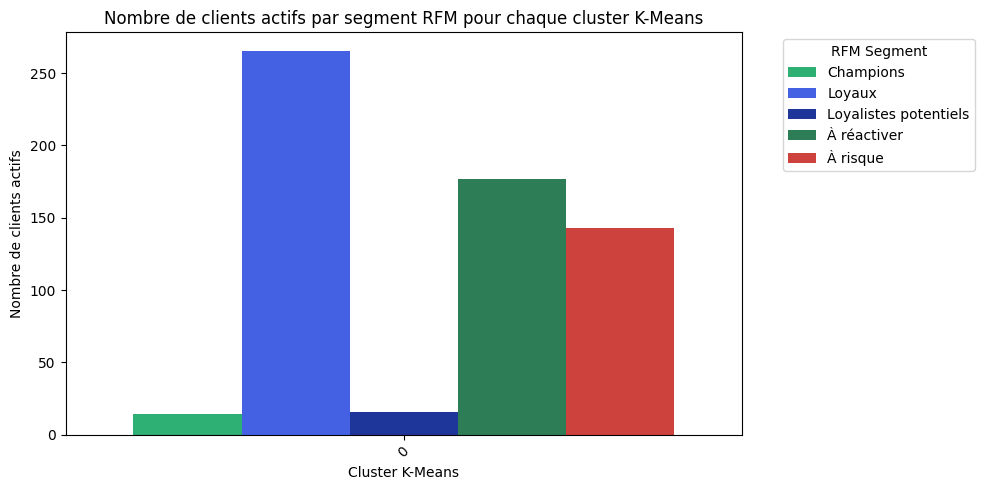

C:\Users\laure\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotly\express\_core.py:1706: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Recency_Score  Frequency_Score Monetary_Score  RFM_Segment
45311             2                1              3  À réactiver
15221             3                1              3     À risque
73285             2                1              2  À réactiver
23140             4                1              3       Loyaux
48776             5                1              1       Loyaux

In [26]:
# Filtrer pour les 3 % les plus actifs
active_customers = sample[sample['Importance_1.0'] == 1]

# Appliquer la même fonction d'attribution des segments RFM aux clients actifs
active_customers.loc[:, 'RFM_Segment'] = active_customers.apply(assign_rfm_segment, axis=1)

# Analyse des segments RFM pour les clients actifs dans chaque cluster
active_cluster_rfm_analysis = active_customers.groupby(['Cluster_KMeans', 'RFM_Segment']).size().reset_index(name='Count')

# Trier les segments RFM pour les clients actifs dans l'ordre spécifié
rfm_segments_order = ["Champions", "Loyaux", "Loyalistes potentiels", "À réactiver", "À risque"]
active_cluster_rfm_analysis['RFM_Segment'] = pd.Categorical(active_cluster_rfm_analysis['RFM_Segment'], categories=rfm_segments_order, ordered=True)
active_cluster_rfm_analysis.sort_values(by=['Cluster_KMeans', 'RFM_Segment'], inplace=True)

# Définir les couleurs personnalisées pour chaque segment RFM
palette = {
    "Champions": "#18c474",
    "Loyaux": "#2950ff",
    "Loyalistes potentiels": "#0a28ad",
    "À réactiver": "#1f8c56",
    "À risque": "#e62b25"
}

# Visualisation du nombre de clients actifs de chaque segment pour chaque cluster
plt.figure(figsize=(10, 5))
sns.barplot(x='Cluster_KMeans', y='Count', hue='RFM_Segment', data=active_cluster_rfm_analysis, palette=palette)
plt.title('Nombre de clients actifs par segment RFM pour chaque cluster K-Means')
plt.xlabel('Cluster K-Means')
plt.ylabel('Nombre de clients actifs')
plt.xticks(rotation=45)
plt.legend(title='RFM Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Préparer les données pour le treemap
df_treemap = active_cluster_rfm_analysis.copy()
df_treemap['Color'] = df_treemap['RFM_Segment'].map(palette)

# Créer un treemap pour chaque cluster
for cluster in df_treemap['Cluster_KMeans'].unique():
    cluster_data = df_treemap[df_treemap['Cluster_KMeans'] == cluster]
    fig = px.treemap(cluster_data,
                     path=['RFM_Segment'],
                     values='Count',
                     color='RFM_Segment',
                     color_discrete_map=palette,
                     title=f'Treemap des segments RFM pour les clients actifs dans le Cluster {cluster}')
    fig.show()

# Vérifier les segments RFM des clients actifs
active_customers[['Recency_Score', 'Frequency_Score', 'Monetary_Score', 'RFM_Segment']].head()

En se concentrant sur les 3 % de clients les plus actifs, nous avons identifié des comportements clés pour un ciblage précis. Les segments de "Champions", "Loyalistes potentiels" et même les clients "À risque" dans ce groupe actif offrent une opportunité d'optimiser les stratégies de marketing et de communication pour augmenter l'engagement et la conversion.